<center> Statistical Thinking in Data Science <center>

# Exploratory Data Analysis & Modelling - AT2

In [475]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from tqdm import tqdm
import itertools


from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.stats.diagnostic import het_arch
import statsmodels.api as sm

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from scipy.stats import shapiro

from arch import arch_model
import arch

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from statsmodels.tsa.api import VAR
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalExponentialSmoothing
import warnings

warnings.filterwarnings('ignore')

In [476]:
# load data 
# QLD_data = pd.read_csv('data\\raw\\combined_QLD.csv')
# NSW_data = pd.read_csv('data\\raw\\combined_NSW.csv')
# VIC_data = pd.read_csv('data\\raw\\combined_VIC.csv')

In [477]:
weather_data = pd.read_csv('data/weather/avg_weather_20180101_20250911.csv')

In [478]:
import os 
import glob
for dirname, _, filenames in os.walk('data\\raw\\aemo_data_2018_2025'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

NSW_files = glob.glob('data/raw/aemo_data_2018_2025/NSW1/*.csv')
NSW_data = pd.concat((pd.read_csv(f) for f in NSW_files))

QLD_files = glob.glob('data/raw/aemo_data_2018_2025/QLD1/*.csv')
QLD_data = pd.concat((pd.read_csv(f) for f in QLD_files))

VIC_files = glob.glob('data/raw/aemo_data_2018_2025/VIC1/*.csv')
VIC_data = pd.concat((pd.read_csv(f) for f in VIC_files))

SA_files = glob.glob('data/raw/aemo_data_2018_2025/SA1/*.csv')
SA_data = pd.concat((pd.read_csv(f) for f in SA_files))

TAS_files = glob.glob('data/raw/aemo_data_2018_2025/TAS1/*.csv')
TAS_data = pd.concat((pd.read_csv(f) for f in TAS_files))

data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201801_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201802_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201803_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201804_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201805_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201806_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201807_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201808_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201809_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201810_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201811_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201812_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201901_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201902_NSW1.csv
data\raw\aemo_data_2018_2025\NSW1\PRICE_AND_DEMAND_201903_NSW1

In [479]:
# all_oos = NSW_oos + QLD_oos + VIC_oos
# all_oos.tail()

# Data Preprocessing

In [480]:
dataset_list = [("QLD_data", QLD_data), ("NSW_data", NSW_data), ("VIC_data", VIC_data), ("TAS_data", TAS_data), ("SA_data", SA_data)]
for name, data in dataset_list:
    print(f'{name} information{"-"*30}')
    data.info()
    print('\n')

QLD_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 477840 entries, 0 to 8927
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   REGION          477840 non-null  object 
 1   SETTLEMENTDATE  477840 non-null  object 
 2   TOTALDEMAND     477840 non-null  float64
 3   RRP             477840 non-null  float64
 4   PERIODTYPE      477840 non-null  object 
dtypes: float64(2), object(3)
memory usage: 21.9+ MB


NSW_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 476976 entries, 0 to 8927
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   REGION          476976 non-null  object 
 1   SETTLEMENTDATE  476976 non-null  object 
 2   TOTALDEMAND     476976 non-null  float64
 3   RRP             476976 non-null  float64
 4   PERIODTYPE      476976 non-null  o

In [481]:
# when merging the data, some headers from other tables are included, hence we need to drop those rows
for data in [QLD_data, NSW_data, VIC_data, TAS_data, SA_data]:
    data.drop(data[data['REGION'] == 'REGION'].index, inplace=True)
    data.dropna(subset=['SETTLEMENTDATE'], inplace=True)
    data['SETTLEMENTDATE'] = pd.to_datetime(data['SETTLEMENTDATE'], format='mixed', dayfirst=True) # convert date / hour columns to datetime format
    data['TOTALDEMAND'] = pd.to_numeric(data['TOTALDEMAND']) # convert totaldemand to numeric

In [482]:
for name, data in dataset_list:
    print(f'{name} information{"-"*30}')
    data.info()
    print('\n')

QLD_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 477840 entries, 0 to 8927
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          477840 non-null  object        
 1   SETTLEMENTDATE  477840 non-null  datetime64[ns]
 2   TOTALDEMAND     477840 non-null  float64       
 3   RRP             477840 non-null  float64       
 4   PERIODTYPE      477840 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 21.9+ MB


NSW_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 476976 entries, 0 to 8927
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          476976 non-null  object        
 1   SETTLEMENTDATE  476976 non-null  datetime64[ns]
 2   TOTALDEMAND     476976 non-nul

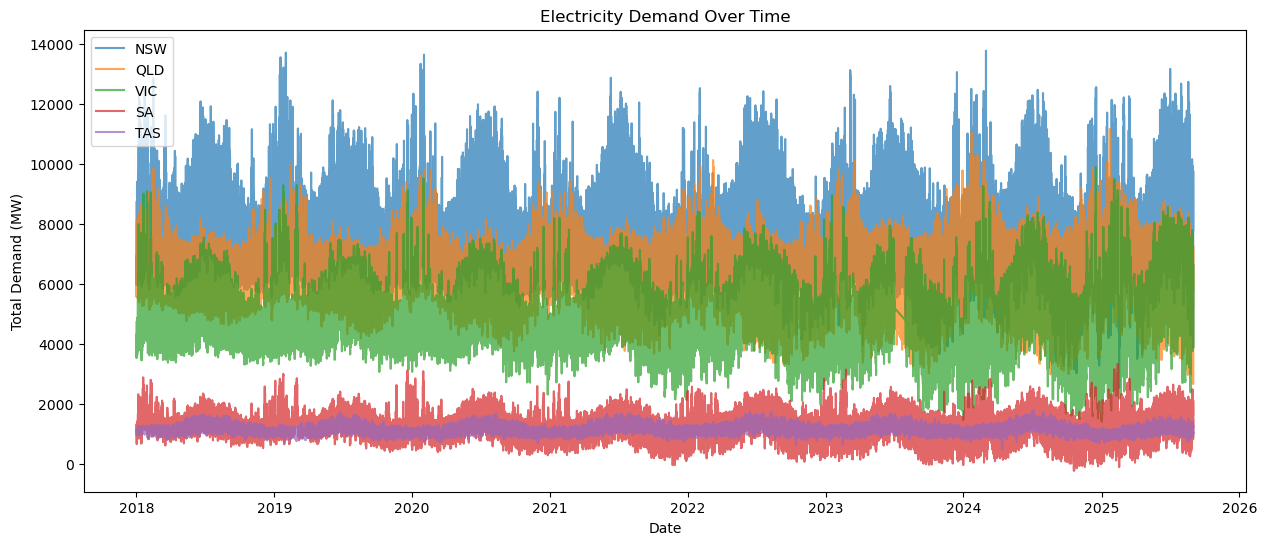

In [483]:
plt.figure(figsize=(15, 6))
plt.plot(NSW_data['SETTLEMENTDATE'], NSW_data['TOTALDEMAND'], label='NSW', alpha=0.7)
plt.plot(QLD_data['SETTLEMENTDATE'], QLD_data['TOTALDEMAND'], label='QLD', alpha=0.7)
plt.plot(VIC_data['SETTLEMENTDATE'], VIC_data['TOTALDEMAND'], label='VIC', alpha=0.7)
plt.plot(SA_data['SETTLEMENTDATE'], SA_data['TOTALDEMAND'], label='SA', alpha=0.7)
plt.plot(TAS_data['SETTLEMENTDATE'], TAS_data['TOTALDEMAND'], label='TAS', alpha=0.7)

plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.show()

# Seasonality

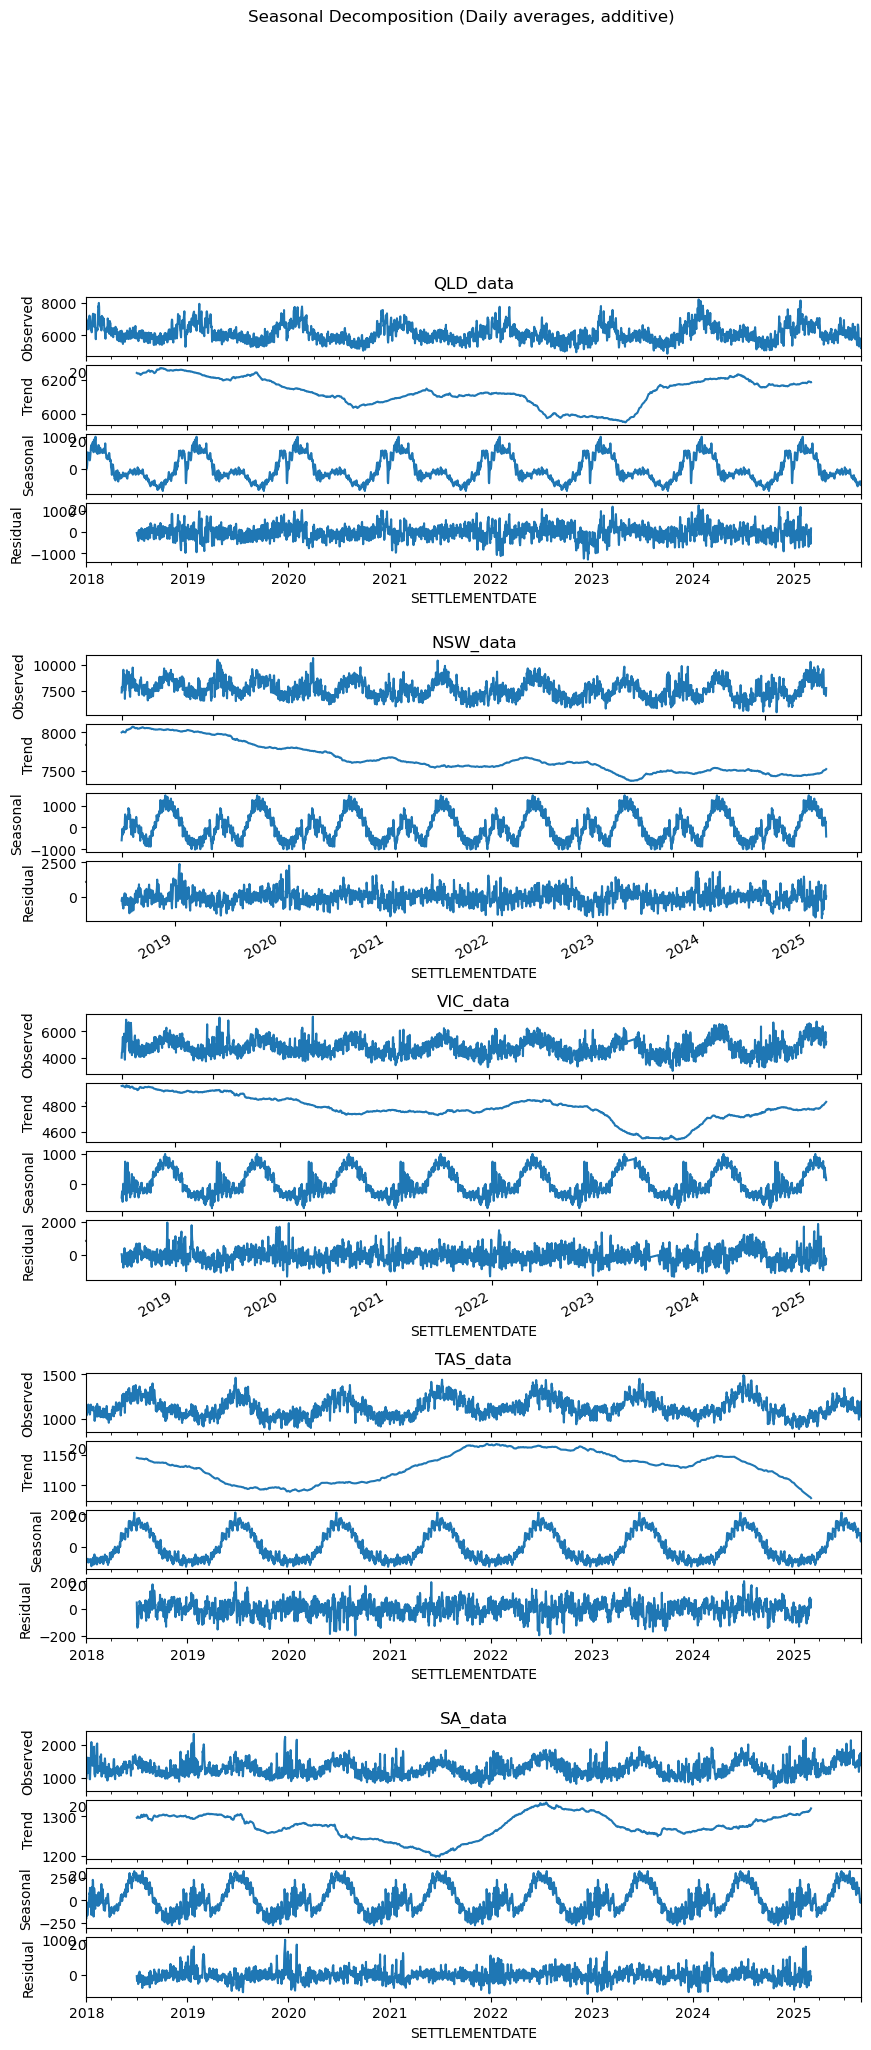

In [484]:
fig = plt.figure(figsize=(10, 5*len(dataset_list)))
outer = GridSpec(len(dataset_list), 1, hspace=0.35)

for i, (name, df) in enumerate(dataset_list):
    df = df.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')
    y = df['TOTALDEMAND'].resample('D').mean().dropna()      # daily avg

    result = seasonal_decompose(y, model='additive', period=365)  # daily → yearly cycle

    inner = GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[i], hspace=0.15)
    ax0 = plt.Subplot(fig, inner[0]); result.observed.plot(ax=ax0); ax0.set_title(name); ax0.set_ylabel('Observed'); fig.add_subplot(ax0)
    ax1 = plt.Subplot(fig, inner[1]); result.trend.plot(ax=ax1);    ax1.set_ylabel('Trend');    fig.add_subplot(ax1)
    ax2 = plt.Subplot(fig, inner[2]); result.seasonal.plot(ax=ax2); ax2.set_ylabel('Seasonal'); fig.add_subplot(ax2)
    ax3 = plt.Subplot(fig, inner[3]); result.resid.plot(ax=ax3);    ax3.set_ylabel('Residual'); fig.add_subplot(ax3)

fig.suptitle('Seasonal Decomposition (Daily averages, additive)', y=0.995)
plt.tight_layout()
plt.show()

🔎 NSW

Trend: steady decline from 2018–2021, then flattening. Likely reflects efficiency improvements, rooftop solar, or economic shifts.

Seasonal: strong yearly cycle — winter heating + summer cooling demand visible as peaks.

Residual: noise around events (heatwaves, system shocks).

🔎 QLD

Trend: more stable, but still downward drift after 2020, then sharper fall in late 2022.

Seasonal: clear yearly cycle, though smaller amplitude than NSW.

Residual: a bit noisier, QLD has more weather-driven spikes.

🔎 VIC

Trend: gradual decline, with some recovery in 2022.

Seasonal: very consistent annual seasonality — winter peaks stand out.

Residual: spikes in 2019–2020 (likely extreme events).

# Frequency Dynamics

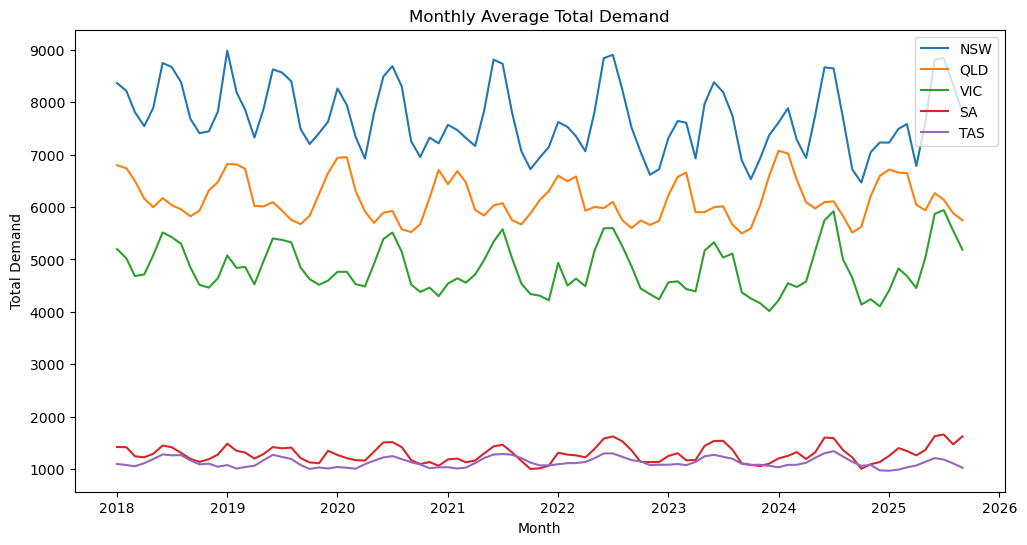

In [485]:
# resample the data to quarter frequency and calculate the mean
NSW = NSW_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
QLD = QLD_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
VIC = VIC_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
SA = SA_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
TAS = TAS_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']

NSW_m = NSW.resample('MS').mean().rename('NSW')
QLD_m = QLD.resample('MS').mean().rename('QLD')
VIC_m = VIC.resample('MS').mean().rename('VIC')
TAS_m = TAS.resample('MS').mean().rename('TAS')
SA_m = SA.resample('MS').mean().rename('SA')

plt.figure(figsize=(12,6))
plt.plot(NSW_m.index, NSW_m.values, label='NSW')
plt.plot(QLD_m.index, QLD_m.values, label='QLD')
plt.plot(VIC_m.index, VIC_m.values, label='VIC')
plt.plot(SA_m.index, SA_m.values, label='SA')
plt.plot(TAS_m.index, TAS_m.values, label='TAS')

plt.title('Monthly Average Total Demand')
plt.xlabel('Month')
plt.ylabel('Total Demand')
plt.legend()
plt.show()

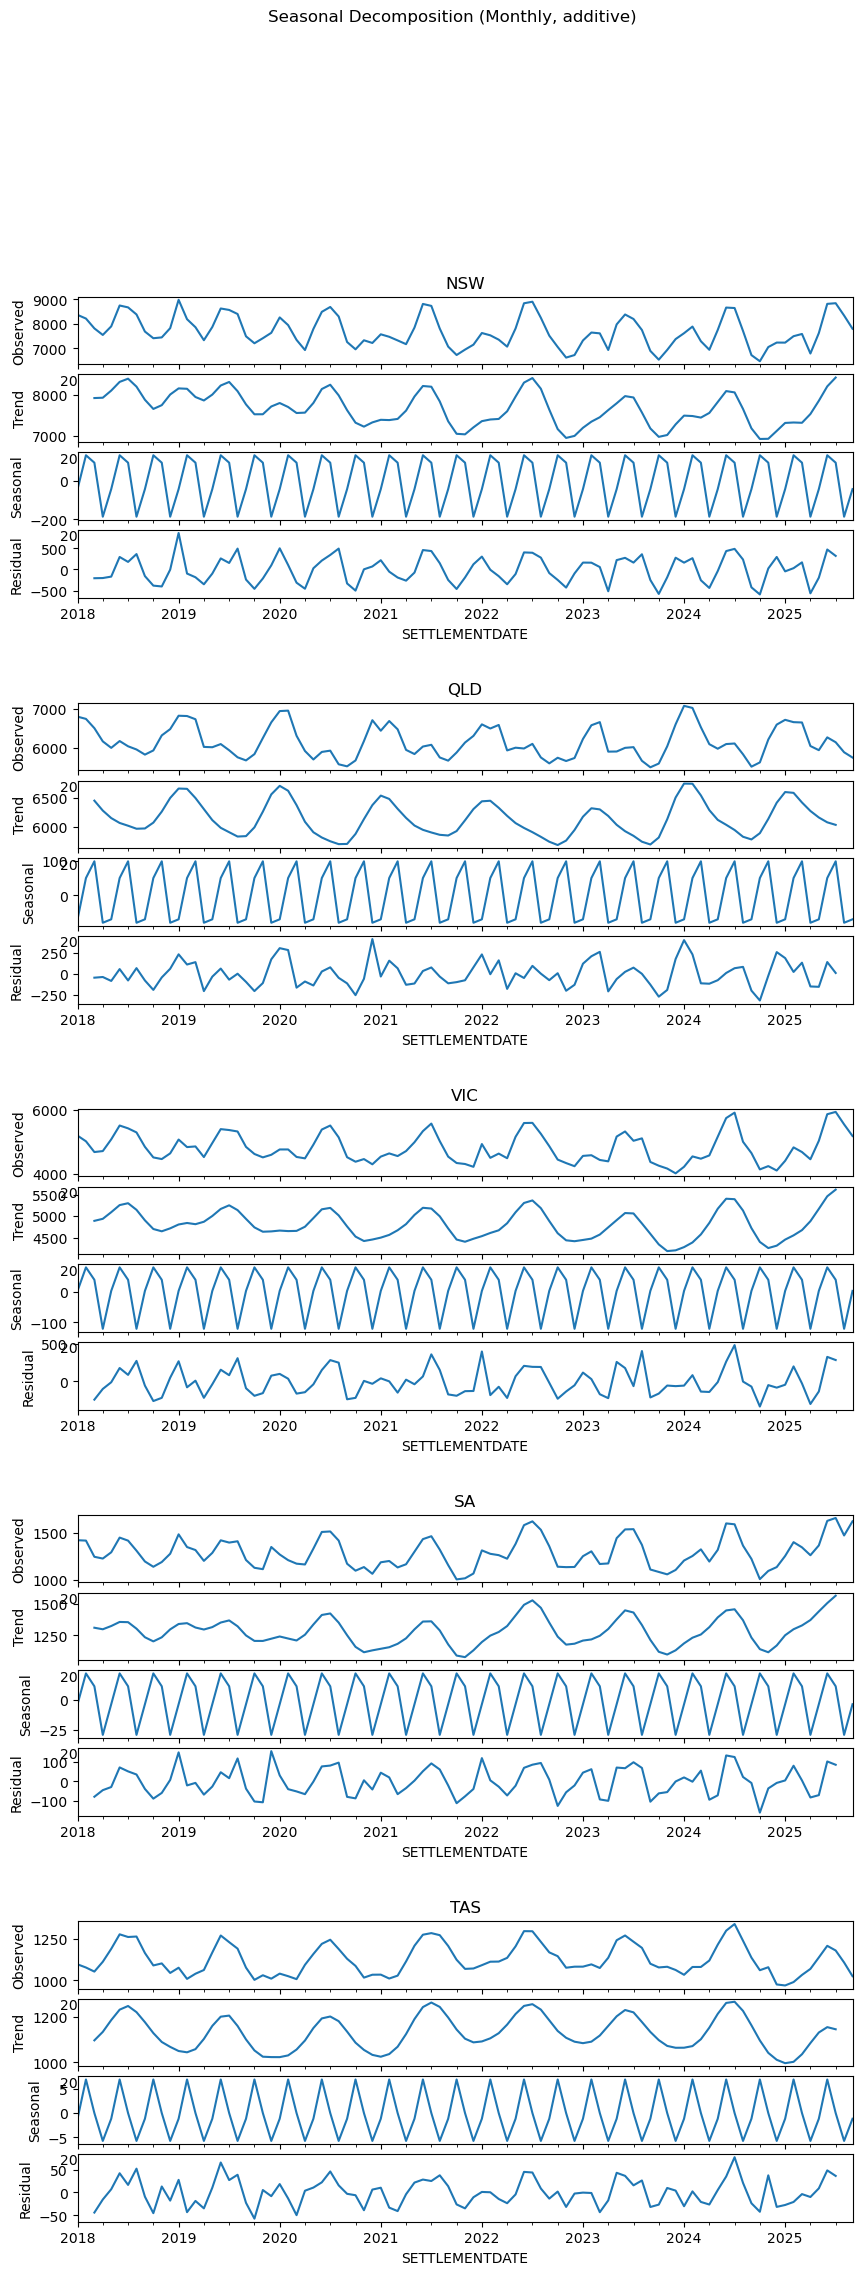

In [486]:
q_datalist = [("NSW", NSW_m), ("QLD", QLD_m), ("VIC", VIC_m), ("SA", SA_m), ("TAS", TAS_m)]
fig = plt.figure(figsize=(10, 5*len(q_datalist)))
outer = GridSpec(len(q_datalist), 1, hspace=0.35)

for i, (name, df) in enumerate(q_datalist):
    y = df.sort_index().dropna()           # Series with DatetimeIndex
    result = seasonal_decompose(y, model='additive', period=4)  # 4 quarters = yearly cycle

    inner = GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[i], hspace=0.15)
    ax0 = plt.Subplot(fig, inner[0]); result.observed.plot(ax=ax0); ax0.set_title(name); ax0.set_ylabel('Observed'); fig.add_subplot(ax0)
    ax1 = plt.Subplot(fig, inner[1]); result.trend.plot(ax=ax1);    ax1.set_ylabel('Trend');    fig.add_subplot(ax1)
    ax2 = plt.Subplot(fig, inner[2]); result.seasonal.plot(ax=ax2); ax2.set_ylabel('Seasonal'); fig.add_subplot(ax2)
    ax3 = plt.Subplot(fig, inner[3]); result.resid.plot(ax=ax3);    ax3.set_ylabel('Residual'); fig.add_subplot(ax3)

fig.suptitle('Seasonal Decomposition (Monthly, additive)', y=0.995)
plt.tight_layout()
plt.show()

# Split Data

In [487]:
train_cutoff = pd.to_datetime('2025-01-01')   # month-start
test_end     = pd.to_datetime('2025-09-01')   # predict 3 quarters of 2025

def split_by_index(s, train_start=None, train_cutoff=None, test_end=None):
    s = s.sort_index()
    if train_start is None:
        train_start = s.index.min()
    train = s.loc[(s.index >= train_start) & (s.index < train_cutoff)]
    test  = s.loc[(s.index >= train_cutoff) & (s.index <= test_end)]
    return train, test

NSW_train, NSW_test = split_by_index(NSW_m, train_cutoff=train_cutoff, test_end=test_end)
QLD_train, QLD_test = split_by_index(QLD_m, train_cutoff=train_cutoff, test_end=test_end)
VIC_train, VIC_test = split_by_index(VIC_m, train_cutoff=train_cutoff, test_end=test_end)
SA_train, SA_test = split_by_index(SA_m, train_cutoff=train_cutoff, test_end=test_end)
TAS_train, TAS_test = split_by_index(TAS_m, train_cutoff=train_cutoff, test_end=test_end)

print('NSW:', NSW_train.shape, NSW_test.shape,
      NSW_train.index.min(), '→', NSW_train.index.max(),
      '|', NSW_test.index.min(), '→', NSW_test.index.max())
print('QLD:', QLD_train.shape, QLD_test.shape,
      QLD_train.index.min(), '→', QLD_train.index.max(),
      '|', QLD_test.index.min(), '→', QLD_test.index.max())
print('VIC:', VIC_train.shape, VIC_test.shape,
      VIC_train.index.min(), '→', VIC_train.index.max(),
      '|', VIC_test.index.min(), '→', VIC_test.index.max())
print('SA:', SA_train.shape, SA_test.shape,
      SA_train.index.min(), '→', SA_train.index.max(),
      '|', SA_test.index.min(), '→', SA_test.index.max())
print('TAS:', TAS_train.shape, TAS_test.shape,
      TAS_train.index.min(), '→', TAS_train.index.max(),
      '|', TAS_test.index.min(), '→', TAS_test.index.max())

NSW: (84,) (9,) 2018-01-01 00:00:00 → 2024-12-01 00:00:00 | 2025-01-01 00:00:00 → 2025-09-01 00:00:00
QLD: (84,) (9,) 2018-01-01 00:00:00 → 2024-12-01 00:00:00 | 2025-01-01 00:00:00 → 2025-09-01 00:00:00
VIC: (84,) (9,) 2018-01-01 00:00:00 → 2024-12-01 00:00:00 | 2025-01-01 00:00:00 → 2025-09-01 00:00:00
SA: (84,) (9,) 2018-01-01 00:00:00 → 2024-12-01 00:00:00 | 2025-01-01 00:00:00 → 2025-09-01 00:00:00
TAS: (84,) (9,) 2018-01-01 00:00:00 → 2024-12-01 00:00:00 | 2025-01-01 00:00:00 → 2025-09-01 00:00:00


# EDA

*Insights*
- NSW highest consumption
- Apparent increase during winter season (May to Sep) across all states
- Clear cyclical and additive seasonal pattern since seasonal amp is roughly consistent

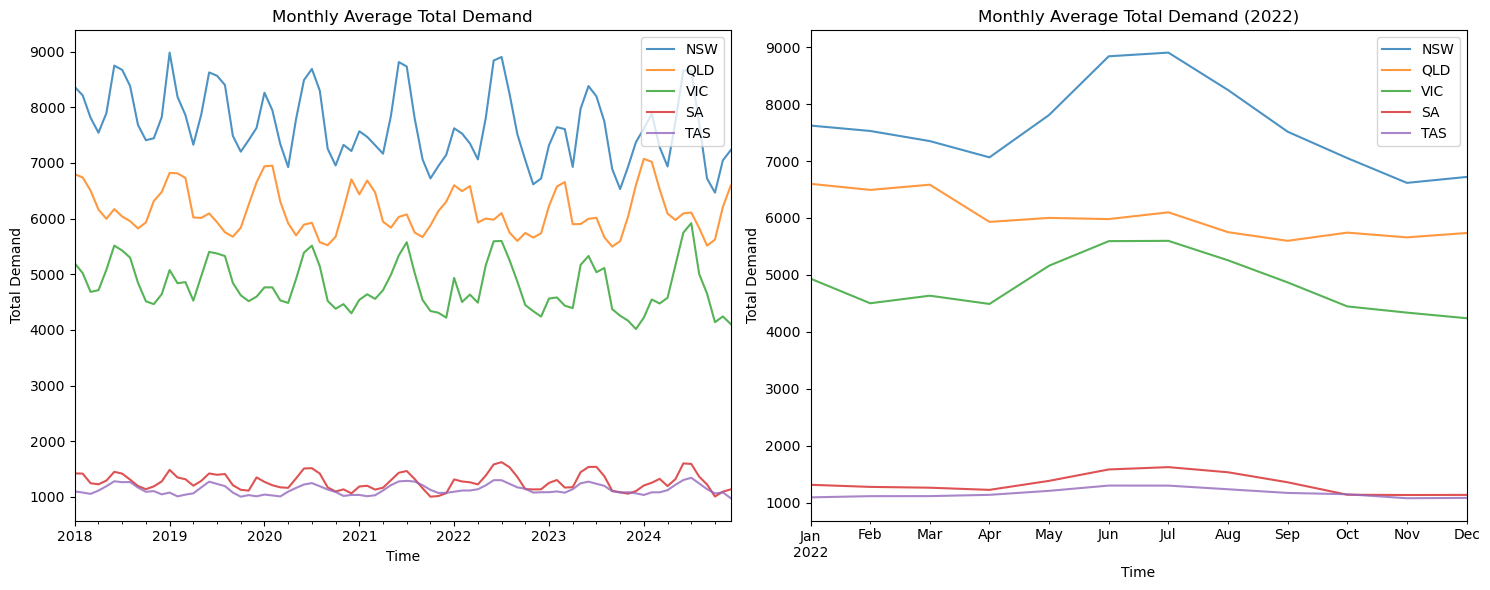

In [488]:
# plot the distribution of total demand over time for each state
train_list = {'NSW': NSW_train, 'QLD': QLD_train, 'VIC': VIC_train, 'SA': SA_train, 'TAS': TAS_train}
plt.figure(figsize=(15, 6))
plt.subplot(121)
for name, s in train_list.items():
    s.sort_index().plot(label=name, alpha=0.8)
plt.title("Monthly Average Total Demand")
plt.xlabel("Time"); plt.ylabel("Total Demand"); plt.legend()

plt.subplot(122)
start_date = '2022-01-01'
end_date   = '2022-12-31'

for name, s in train_list.items():
    s.sort_index().loc[start_date:end_date].plot(label=name, alpha=0.8)
plt.title("Monthly Average Total Demand (2022)")
plt.xlabel("Time"); plt.ylabel("Total Demand"); plt.legend()

plt.tight_layout()
plt.show()

## Stationary

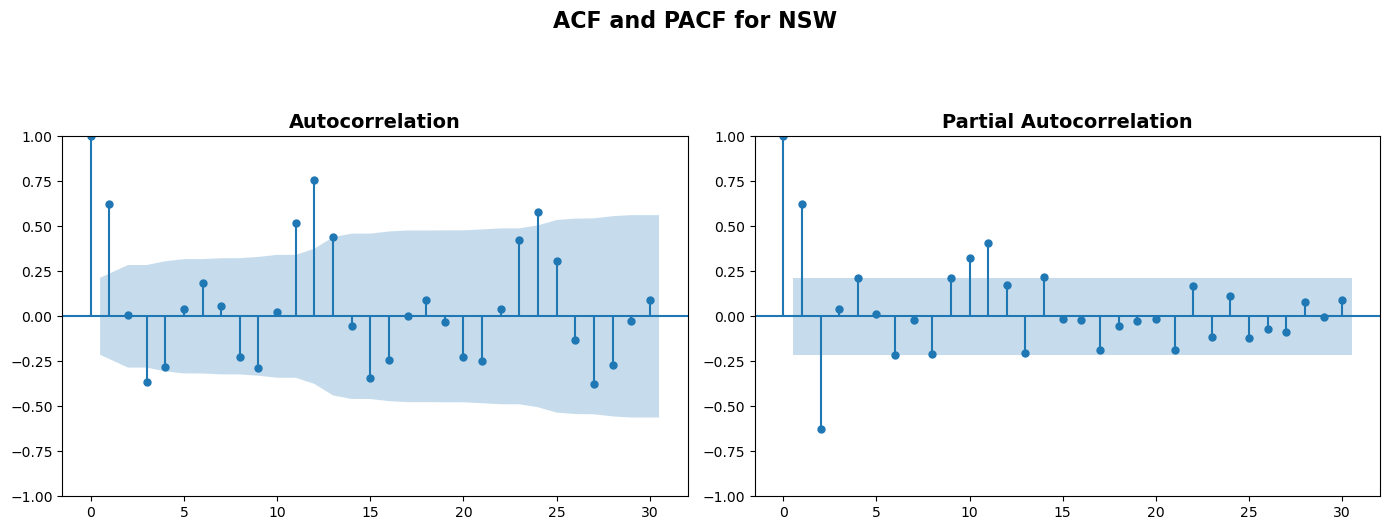

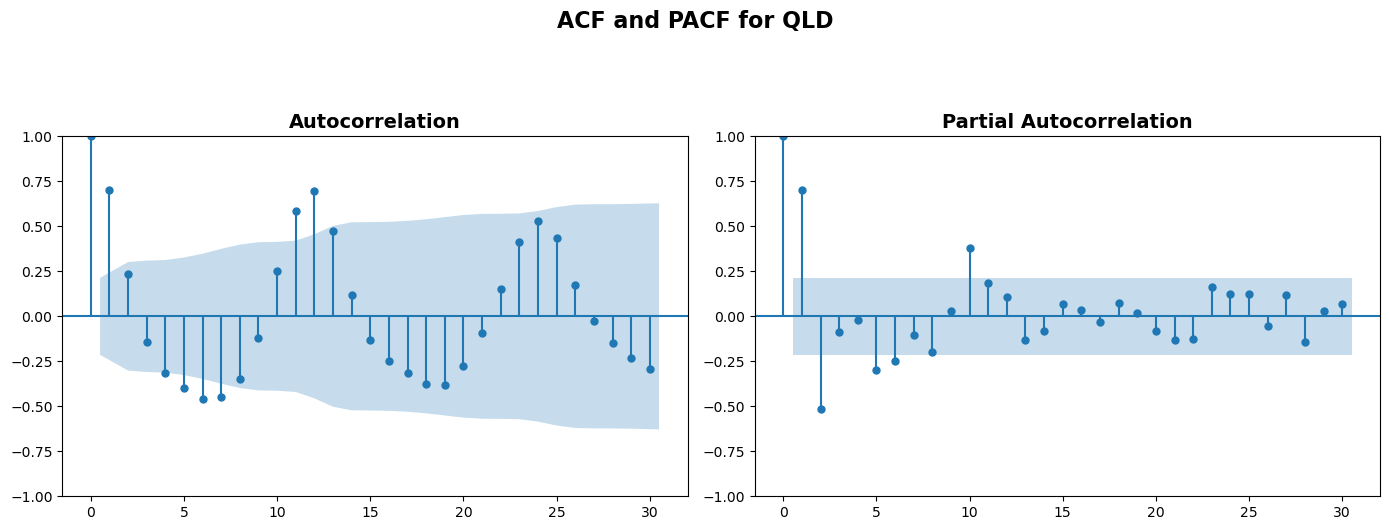

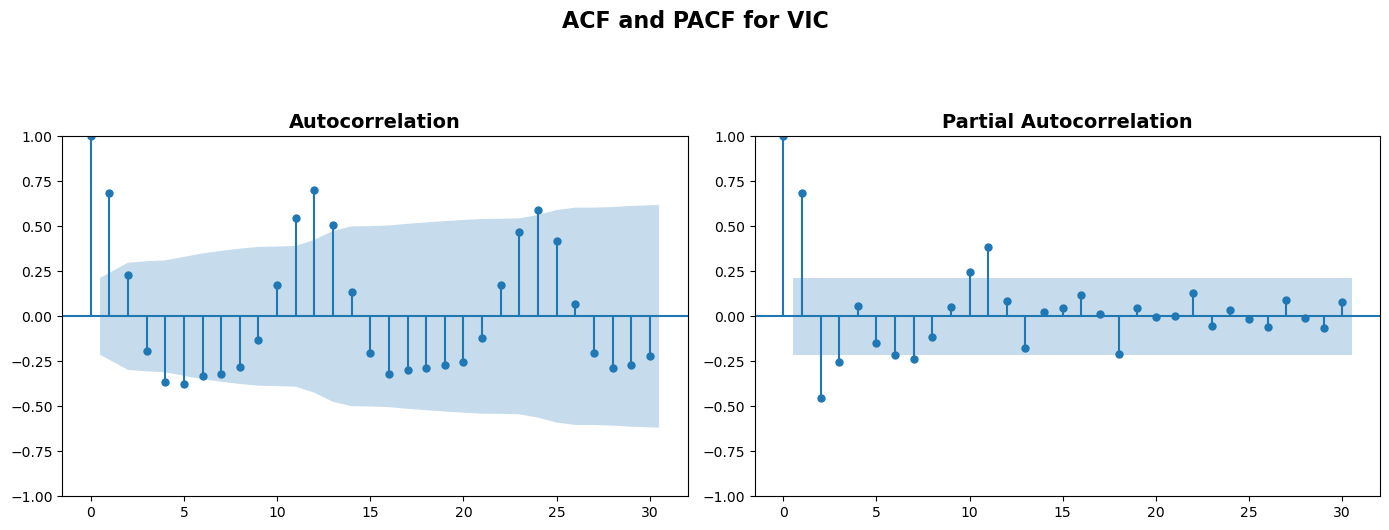

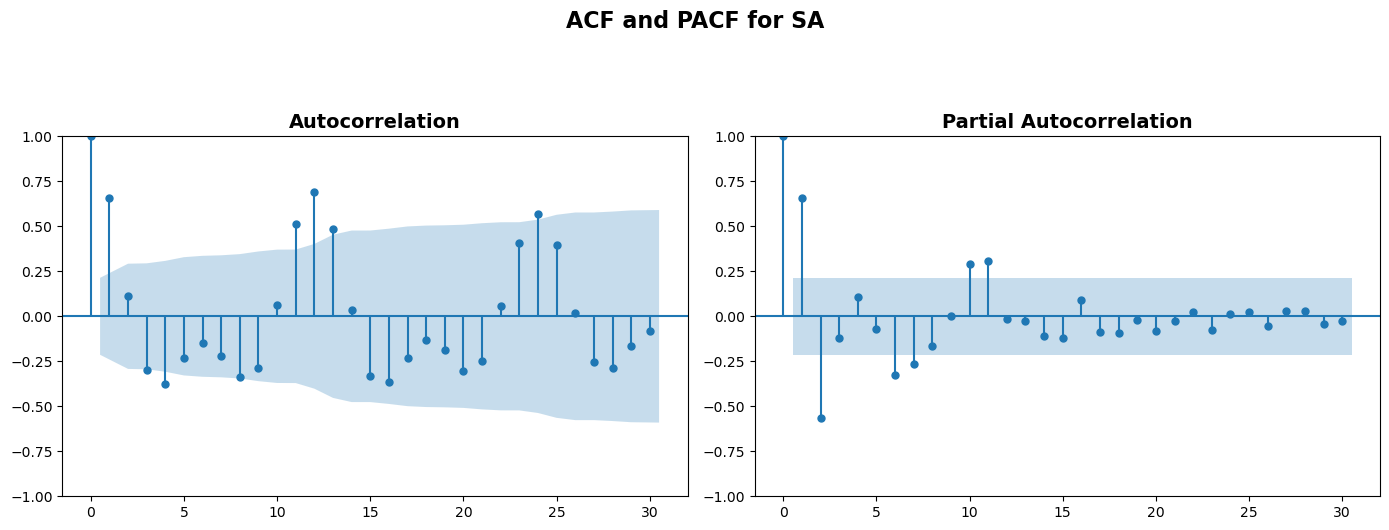

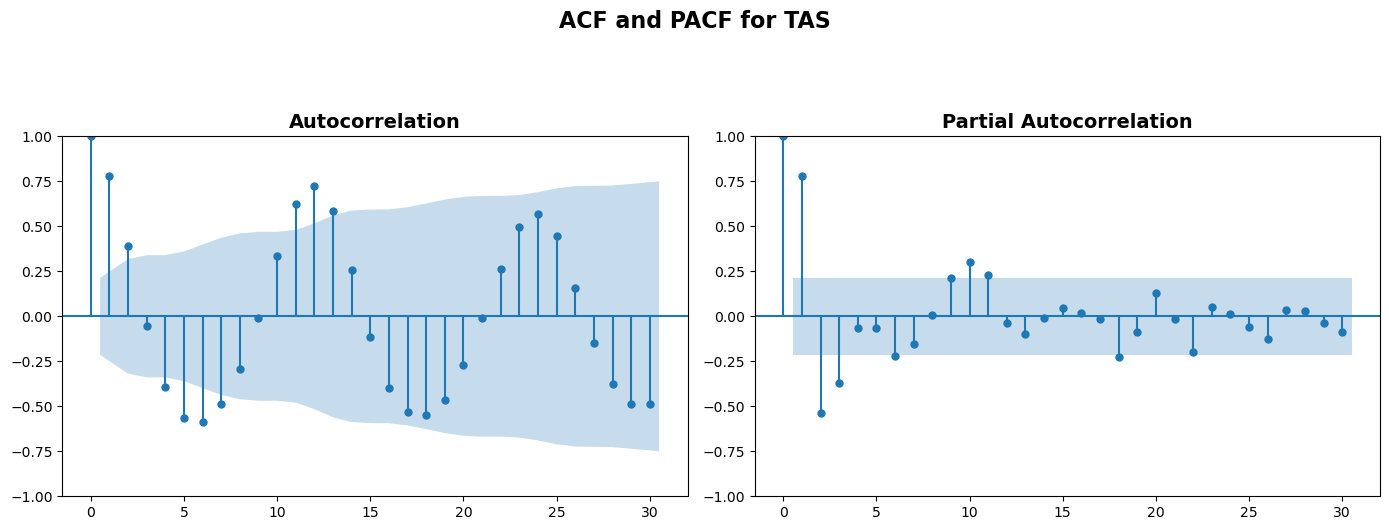

In [489]:
for name, series in train_list.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    # ACF
    sm.graphics.tsa.plot_acf(series, lags=30, alpha=0.05, ax=ax1)
    ax1.set_title("Autocorrelation", fontsize=14, fontweight="bold")
    
    # PACF
    sm.graphics.tsa.plot_pacf(series, lags=30, alpha=0.05, ax=ax2, method="ywm")
    ax2.set_title("Partial Autocorrelation", fontsize=14, fontweight="bold")
    
    fig.suptitle(f"ACF and PACF for {name}", fontsize=16, fontweight="bold", y=1.05)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

In [490]:
# adfuller test: statistical test used to determine if a time series is stationary or not by testing for the presence of a unit root. 
# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root. 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

adf_results = []

for name, series in train_list.items():
    test = adfuller(series.dropna())
    adf_results.append({
        'name': name,
        'statistic': test[0],
        'pvalue': test[1],
        'n_lags': test[2],
        'n_obs': test[3],
        'crit_1%': test[4]['1%'],
        'crit_5%': test[4]['5%'],
        'crit_10%': test[4]['10%']
    })

df_adf = pd.DataFrame(adf_results)
print(df_adf)

  name  statistic    pvalue  n_lags  n_obs   crit_1%   crit_5%  crit_10%
0  NSW  -2.056957  0.262171      12     71 -3.526005 -2.903200 -2.588995
1  QLD  -1.777827  0.391524      10     73 -3.523284 -2.902031 -2.588371
2  VIC  -1.500427  0.533300      11     72 -3.524624 -2.902607 -2.588679
3   SA  -1.663569  0.449974      10     73 -3.523284 -2.902031 -2.588371
4  TAS  -1.272960  0.641450      12     71 -3.526005 -2.903200 -2.588995


Failed to reject H0 -> non-stationary

## Data transformation

### Differencing

In [491]:
m = 12 
NSW_diff = NSW_train.diff(m).dropna()
QLD_diff = QLD_train.diff(m).dropna()
VIC_diff = VIC_train.diff(m).dropna()
SA_diff = SA_train.diff(m).dropna()
TAS_diff = TAS_train.diff(m).dropna()

# re-test stationarity after differencing
adf_results_diff = []
for name, series in zip(['NSW', 'QLD', 'VIC', 'SA', 'TAS'], [NSW_diff, QLD_diff, VIC_diff, SA_diff, TAS_diff]):
    test = adfuller(series.dropna())
    adf_results_diff.append({
        'name': name,
        'statistic': test[0],
        'pvalue': test[1],
        'n_lags': test[2],
        'n_obs': test[3],
        'crit_1%': test[4]['1%'],
        'crit_5%': test[4]['5%'],
        'crit_10%': test[4]['10%']
    })

df_adf_diff = pd.DataFrame(adf_results_diff)
print(df_adf_diff)

  name  statistic    pvalue  n_lags  n_obs   crit_1%   crit_5%  crit_10%
0  NSW  -4.899513  0.000035       3     68 -3.530399 -2.905087 -2.590001
1  QLD  -3.521829  0.007444      11     60 -3.544369 -2.911073 -2.593190
2  VIC  -3.747611  0.003491      11     60 -3.544369 -2.911073 -2.593190
3   SA  -2.901420  0.045183      12     59 -3.546395 -2.911939 -2.593652
4  TAS  -3.706016  0.004029       0     71 -3.526005 -2.903200 -2.588995


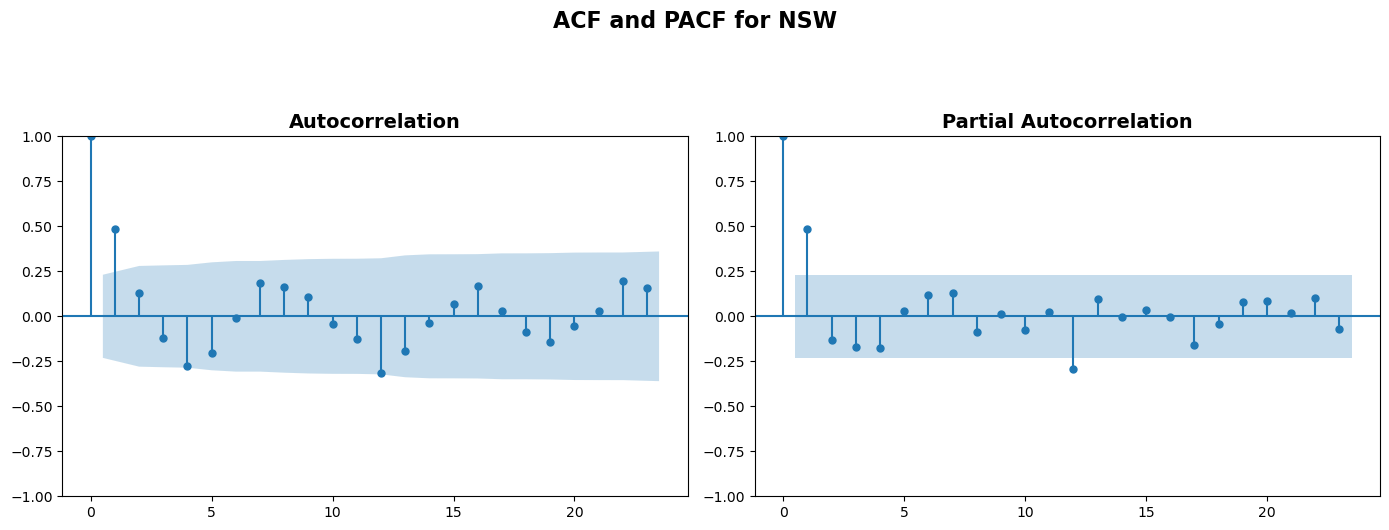

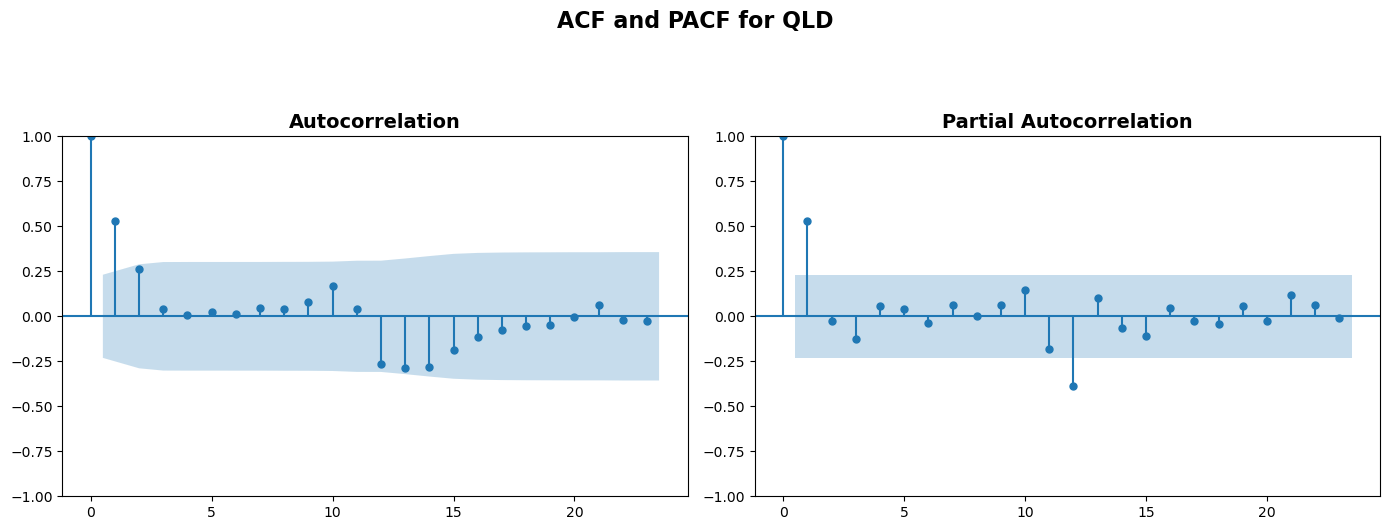

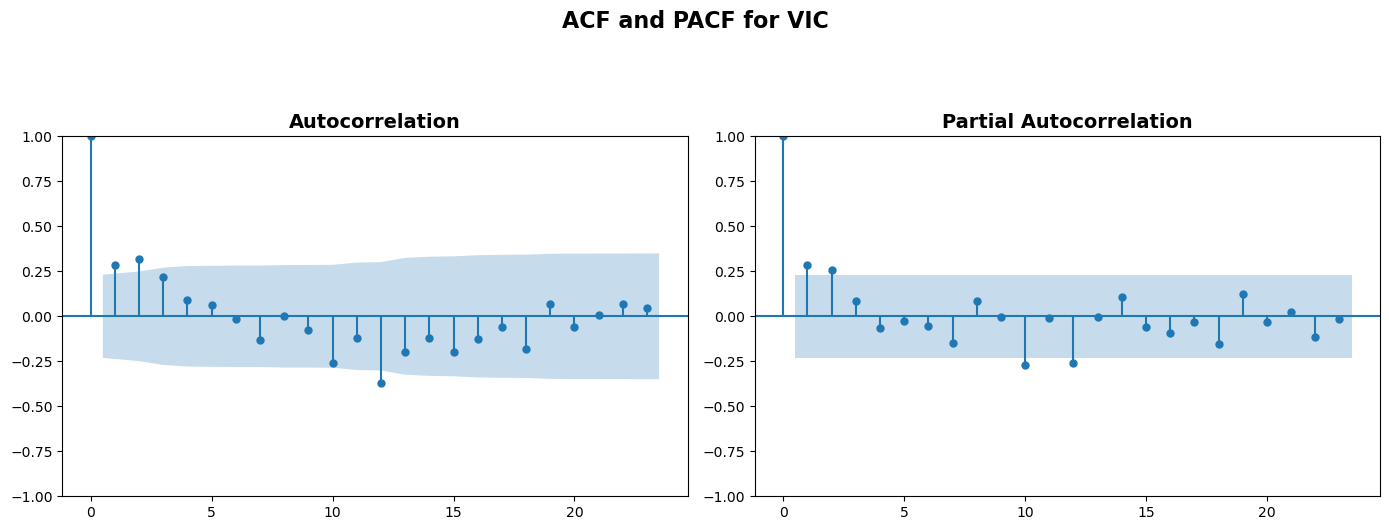

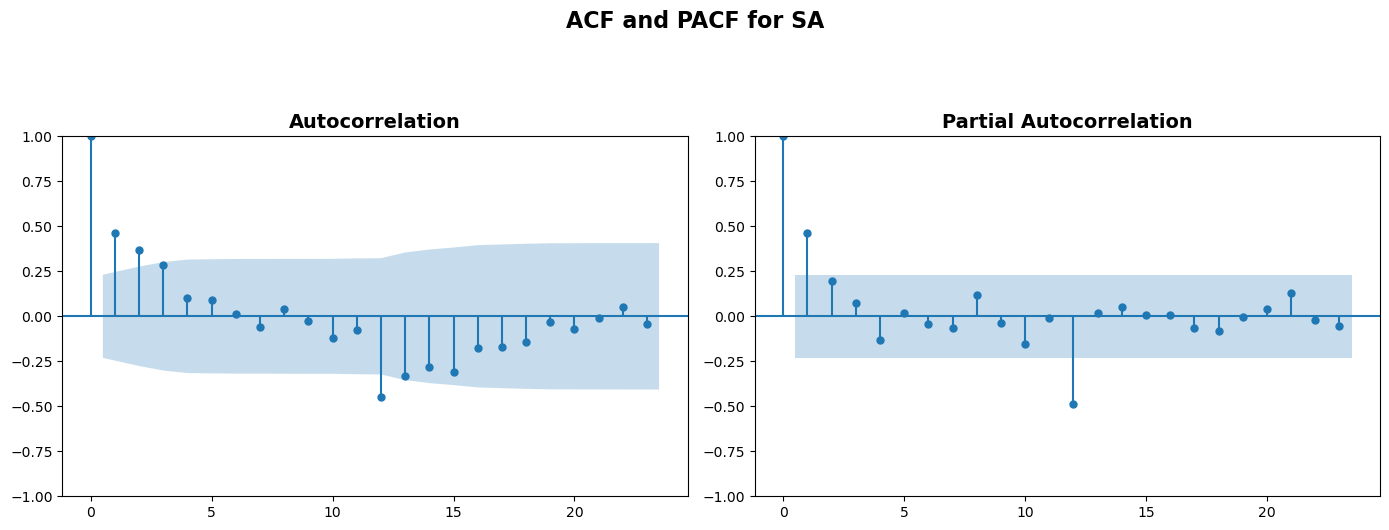

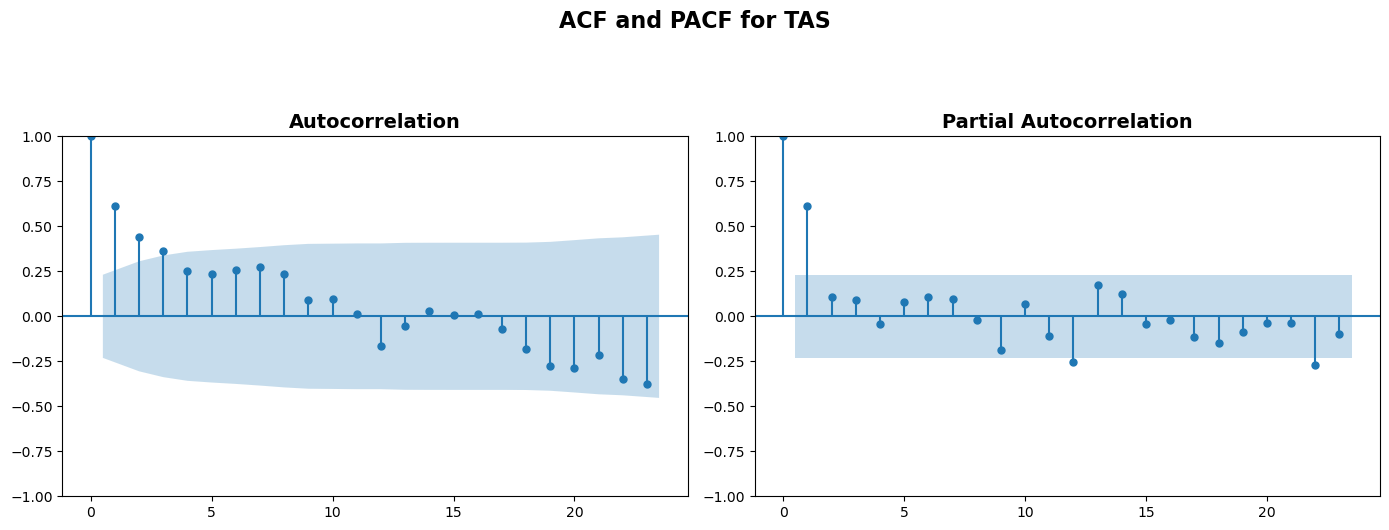

In [492]:
diff_list = {'NSW': NSW_diff, 'QLD': QLD_diff, 'VIC': VIC_diff, 'SA': SA_diff, 'TAS': TAS_diff}

for name, series in diff_list.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    # ACF
    sm.graphics.tsa.plot_acf(series, lags=23, alpha=0.05, ax=ax1)
    ax1.set_title("Autocorrelation", fontsize=14, fontweight="bold")
    
    # PACF
    sm.graphics.tsa.plot_pacf(series, lags=23, alpha=0.05, ax=ax2, method="ywm")
    ax2.set_title("Partial Autocorrelation", fontsize=14, fontweight="bold")
    
    fig.suptitle(f"ACF and PACF for {name}", fontsize=16, fontweight="bold", y=1.05)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Modelling

## Seasonal Random Walk

In [493]:
season_length = 12  # monthly data with yearly seasonality
seasonal_rw_df = pd.DataFrame(index=NSW_test.index)

for name, series in train_list.items():
    history = series.dropna()
    forecast = []

    for h in range(1, len(NSW_test) + 1): 
        k = ((h - 1) // season_length) + 1
        index = -season_length * k

        if abs(index) >= len(history):
            yhat = history.iloc[-1] # fallback to last observation
        else: 
            yhat = history.iloc[index]

        forecast.append(yhat)

    seasonal_rw_df[name] = forecast

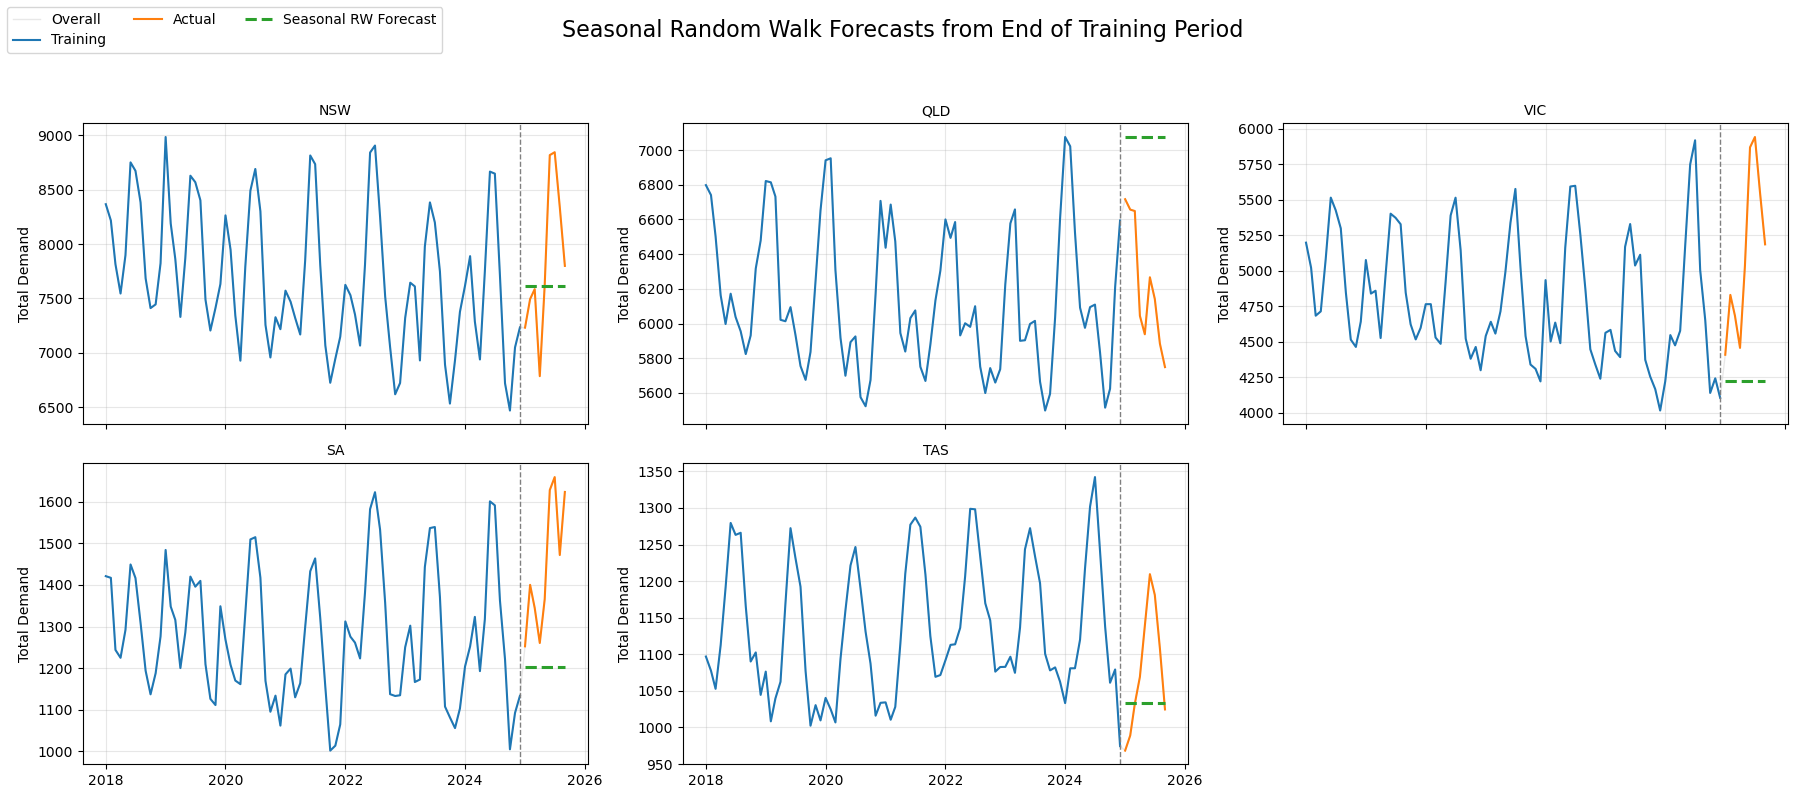

In [494]:
test_list = {'NSW': NSW_test, 'QLD': QLD_test, 'VIC': VIC_test, 'SA': SA_test, 'TAS': TAS_test}
import matplotlib.dates as mdates

# dicts of Series (same keys): train_list, test_list
# DataFrame of forecasts with columns matching the keys: seasonal_rw_df
forecast_model_df_seasonal = seasonal_rw_df

names = list(train_list.keys())            # ['NSW','QLD','VIC']
n_cols = 3
n_rows = int(np.ceil(len(names) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = np.atleast_1d(axes).ravel()

def idx_to_ts(s):
    idx = s.index
    return idx.to_timestamp() if hasattr(idx, 'to_timestamp') else idx

for i, name in enumerate(names):
    ax = axes[i]

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = forecast_model_df_seasonal[name]       # Series or DataFrame column

    # X values (handle PeriodIndex or DatetimeIndex)
    x_tr = idx_to_ts(tr)
    x_te = idx_to_ts(te)
    x_fc = idx_to_ts(fc)
    
    combined = pd.concat([tr, te])
    ax.plot(combined.index, combined.values, color='lightgray', alpha=0.5, label='Overall', lw=1)

    ax.plot(x_tr, tr.values, label='Training', color='#1f77b4', lw=1.5)
    ax.plot(x_te, te.values, label='Actual',   color='#ff7f0e', lw=1.5)
    ax.plot(x_fc, fc.values, label='Seasonal RW Forecast',
            color='#2ca02c', lw=2.2, ls='--')

    # vertical split marker at end of training
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)

    ax.set_title(name, fontsize=10)
    ax.set_ylabel('Total Demand')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=3, fontsize=10)
fig.suptitle("Seasonal Random Walk Forecasts from End of Training Period", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [495]:
import numpy as np
import pandas as pd

def mae(a, b): 
    a = np.asarray(a); b = np.asarray(b)
    return np.mean(np.abs(a - b))

def rmse(a, b): 
    a = np.asarray(a); b = np.asarray(b)
    return np.sqrt(np.mean((a - b) ** 2))

def mape(a, b):  # safer MAPE (avoid div-by-zero)
    a = np.asarray(a); b = np.asarray(b)
    denom = np.where(a == 0, 1e-9, np.abs(a))
    return np.mean(np.abs((a - b) / denom)) * 100

results = pd.DataFrame(columns=['Region', 'MAE', 'RMSE', 'MAPE', 'N'])

# accumulators for MICRO/pooled metrics
sse_total = 0.0
abs_err_total = 0.0
abs_pct_err_total = 0.0
n_total = 0

for name in names:
    tr = train_list[name]                 # Series
    te = test_list[name]                  # Series
    fc = forecast_model_df_seasonal[name] # Series or single-col DataFrame

    # ensure forecast is a 1D Series
    if isinstance(fc, pd.DataFrame):
        fc = fc.iloc[:, 0]

    # align to common test index
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]

    # per-region metrics
    mae_value  = mae(te_aligned.values,  fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    n_i = len(common_index)

    results = pd.concat([results, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value],
        'N': [n_i]
    })], ignore_index=True)

    # update pooled accumulators
    diff = te_aligned.values - fc_aligned.values
    sse_total += np.sum(diff**2)
    abs_err_total += np.sum(np.abs(diff))
    abs_pct_err_total += np.sum(np.abs(diff) / np.where(te_aligned.values==0, 1e-9, np.abs(te_aligned.values)))
    n_total += n_i

# sort and show per-region
print('HW Seasonal RW')
results = results.sort_values('RMSE')
print(results[['Region','MAE','RMSE','MAPE','N']])

# --- OVERALL metrics ---
# Macro (each region weighs the same)
overall_rmse_macro = results['RMSE'].mean()
overall_mae_macro  = results['MAE'].mean()
overall_mape_macro = results['MAPE'].mean()

# Micro / pooled (each observation weighs the same)
overall_rmse_micro = np.sqrt(sse_total / n_total)
overall_mae_micro  = abs_err_total / n_total
overall_mape_micro = (abs_pct_err_total / n_total) * 100

print(f"\nOverall RMSE (macro avg): {overall_rmse_macro:.3f}")
print(f"Overall RMSE (micro/pooled): {overall_rmse_micro:.3f}")
print(f"Overall MAE  (micro/pooled): {overall_mae_micro:.3f}")
print(f"Overall MAPE (micro/pooled): {overall_mape_micro:.3f}%")

HW Seasonal RW
  Region         MAE         RMSE       MAPE  N
4    TAS   73.208222    92.601764   6.506925  9
3     SA  241.213324   283.794917  15.806340  9
0    NSW  523.567694   696.453475   6.471286  9
1    QLD  848.112197   915.801027  13.966357  9
2    VIC  885.436270  1038.686944  16.414102  9

Overall RMSE (macro avg): 605.468
Overall RMSE (micro/pooled): 705.935
Overall MAE  (micro/pooled): 514.308
Overall MAPE (micro/pooled): 11.833%


## Holt Winter's Additive Model

In [496]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw_add = pd.DataFrame(index=NSW_test.index)

for name, series in train_list.items():
    model = ExponentialSmoothing(series, seasonal='add', seasonal_periods=12, initialization_method='estimated').fit()

    hw_add[name] = model.forecast(len(series))

forecast_model_df_hw_add = hw_add.copy()

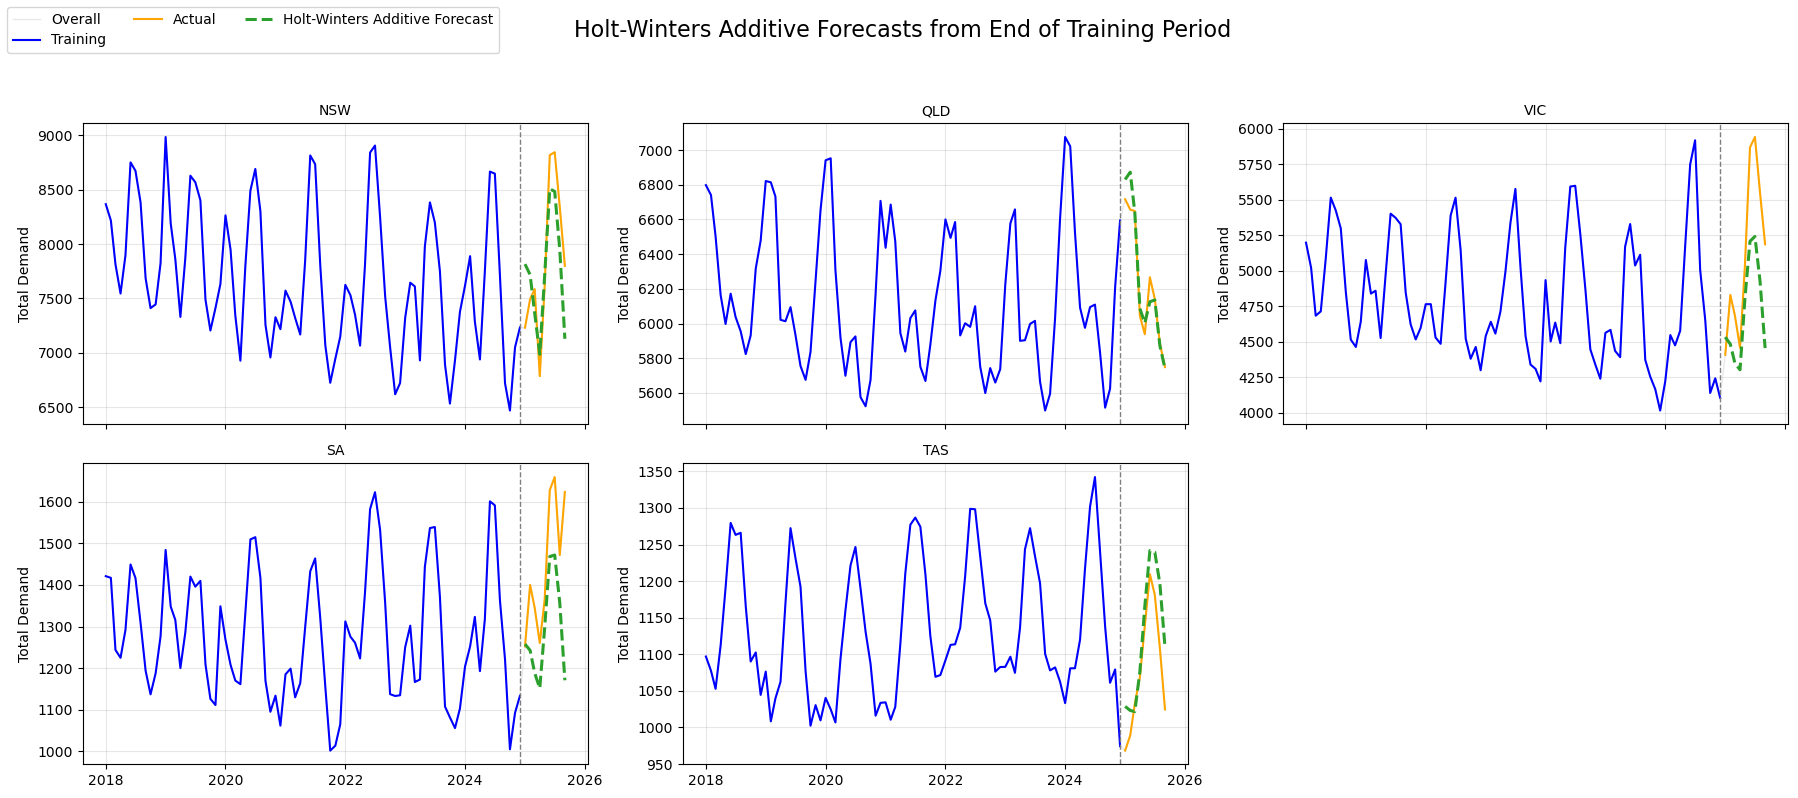

In [497]:
names = list(train_list.keys())            # ['NSW','QLD','VIC']
n_cols = 3
n_rows = int(np.ceil(len(names) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = np.atleast_1d(axes).ravel()

for i, name in enumerate(names):
    ax = axes[i]

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = forecast_model_df_hw_add[name]       # Series or DataFrame column

    # X values (handle PeriodIndex or DatetimeIndex)
    x_tr = idx_to_ts(tr)
    x_te = idx_to_ts(te)
    x_fc = idx_to_ts(fc)
    
    combined = pd.concat([tr, te])
    ax.plot(combined.index, combined.values, color='lightgray', alpha=0.5, label='Overall', lw=1)

    ax.plot(x_tr, tr.values, label='Training', color='blue')
    ax.plot(x_te, te.values, label='Actual',   color='orange')
    ax.plot(x_fc, fc.values, label='Holt-Winters Additive Forecast',
            color='#2ca02c', lw=2.2, ls='--')

    # vertical split marker at end of training
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)

    ax.set_title(name, fontsize=10)
    ax.set_ylabel('Total Demand')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=3, fontsize=10)
fig.suptitle("Holt-Winters Additive Forecasts from End of Training Period", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [498]:
results_hw_add = pd.DataFrame(columns=['Region', 'MAE', 'RMSE', 'MAPE'])

def idx_to_ts(s):
    idx = s.index
    return idx.to_timestamp() if hasattr(idx, 'to_timestamp') else idx

for i, name in enumerate(names):

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = forecast_model_df_hw_add[name]       # Series or DataFrame column
    
    # Ensure test and forecast data align for error metrics
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]
    
    # Calculate error metrics
    mae_value = mae(te_aligned.values, fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    
    # Append to results DataFrame
    results_hw_add = pd.concat([results_hw_add, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value]
    })], ignore_index=True)

# Display results_hw_add sorted by RMSE
print('HW Seasonal Additive')
results_hw_add = results_hw_add.sort_values('RMSE')
print(results_hw_add)

HW Seasonal Additive
  Region         MAE        RMSE       MAPE
4    TAS   44.935658   53.011528   4.194000
1    QLD   68.122440   97.535078   1.062526
3     SA  156.664235  195.534111  10.407554
0    NSW  340.191168  383.222848   4.347290
2    VIC  434.154628  491.691136   8.175901


In [499]:
# --- OVERALL metrics ---
sse_total_hwadd = 0.0
abs_err_total_hwadd = 0.0
abs_pct_err_total_hwadd = 0.0
n_total_hwadd = 0

for name in names:
    tr = train_list[name]                 # Series
    te = test_list[name]                  # Series
    fc = forecast_model_df_hw_add[name] # Series or single-col DataFrame

    # ensure forecast is a 1D Series
    if isinstance(fc, pd.DataFrame):
        fc = fc.iloc[:, 0]

    # align to common test index
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]

    # per-region metrics
    mae_value  = mae(te_aligned.values,  fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    n_i = len(common_index)

    results = pd.concat([results, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value],
        'N': [n_i]
    })], ignore_index=True)

    # update pooled accumulators
    diff = te_aligned.values - fc_aligned.values
    sse_total_hwadd += np.sum(diff**2)
    abs_err_total_hwadd += np.sum(np.abs(diff))
    abs_pct_err_total_hwadd += np.sum(np.abs(diff) / np.where(te_aligned.values==0, 1e-9, np.abs(te_aligned.values)))
    n_total_hwadd += n_i

# sort and show per-region
print('HW Seasonal Additive')
results = results.sort_values('RMSE')
print(results[['Region','MAE','RMSE','MAPE','N']])

# --- OVERALL metrics ---
# Macro (each region weighs the same)
overall_rmse_macro_hwadd = results['RMSE'].mean()
overall_mae_macro_hwadd  = results['MAE'].mean()
overall_mape_macro_hwadd = results['MAPE'].mean()

# Micro / pooled (each observation weighs the same)
overall_rmse_micro_hwadd = np.sqrt(sse_total_hwadd / n_total_hwadd)
overall_mae_micro_hwadd  = abs_err_total_hwadd / n_total_hwadd
overall_mape_micro_hwadd = (abs_pct_err_total_hwadd / n_total_hwadd) * 100

print(f"\nOverall RMSE (macro avg): {overall_rmse_macro_hwadd:.3f}")
print(f"Overall RMSE (micro/pooled): {overall_rmse_micro_hwadd:.3f}")
print(f"Overall MAE  (micro/pooled): {overall_mae_micro_hwadd:.3f}")
print(f"Overall MAPE (micro/pooled): {overall_mape_micro_hwadd:.3f}%")

HW Seasonal Additive
  Region         MAE         RMSE       MAPE  N
9    TAS   44.935658    53.011528   4.194000  9
0    TAS   73.208222    92.601764   6.506925  9
6    QLD   68.122440    97.535078   1.062526  9
8     SA  156.664235   195.534111  10.407554  9
1     SA  241.213324   283.794917  15.806340  9
5    NSW  340.191168   383.222848   4.347290  9
7    VIC  434.154628   491.691136   8.175901  9
2    NSW  523.567694   696.453475   6.471286  9
3    QLD  848.112197   915.801027  13.966357  9
4    VIC  885.436270  1038.686944  16.414102  9

Overall RMSE (macro avg): 424.833
Overall RMSE (micro/pooled): 296.370
Overall MAE  (micro/pooled): 208.814
Overall MAPE (micro/pooled): 5.637%


## Damped HW

In [500]:
holt_damped_df = pd.DataFrame(index=NSW_test.index)

# The number of periods to forecast is the length of the test set index
forecast_horizon = len(NSW_test.index)

for name, series in train_list.items():
    # Add trend='add' to specify the trend component to be dampened
    model = ExponentialSmoothing(
        series,
        trend='add',
        damped_trend=True,
        seasonal='add',
        seasonal_periods=12,
        initialization_method='estimated'
    ).fit()
    
    # Forecast for the length of the test set, not the training set
    forecast_values = model.forecast(forecast_horizon)
    
    # Ensure the forecast index matches the destination DataFrame index
    forecast_values.index = holt_damped_df.index
    
    holt_damped_df[name] = forecast_values

fc_model_hw_add_damped = holt_damped_df.copy()

# print(fc_model_hw_add_damped.head())

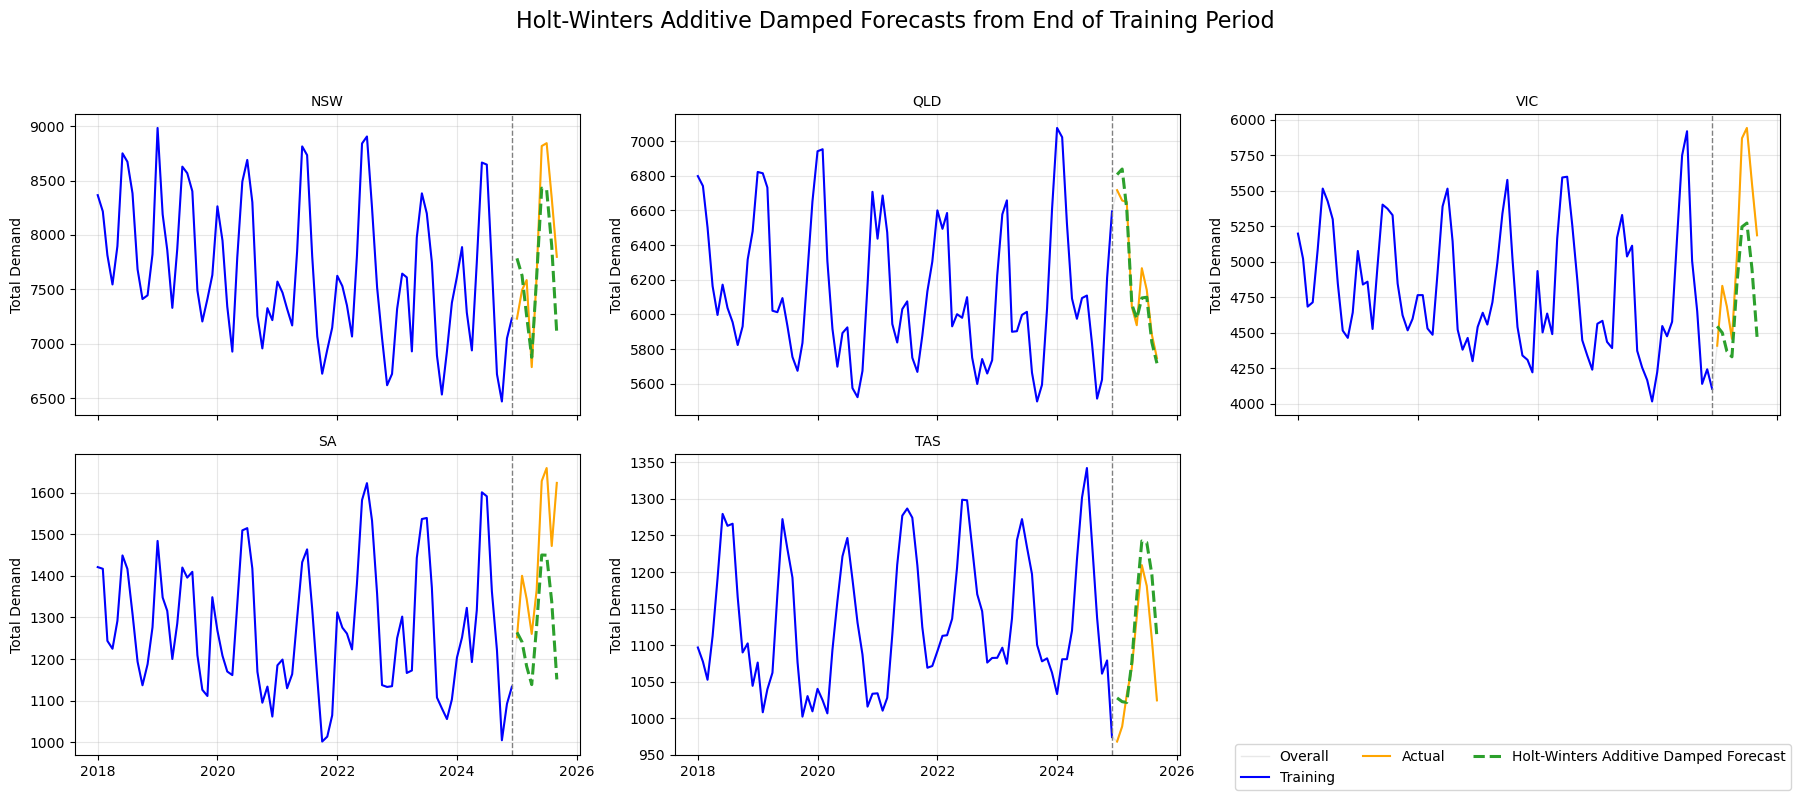

In [501]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)

axes = axes.flatten()

for i, name in enumerate(names):
    ax = axes[i]

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = fc_model_hw_add_damped[name]       # Series or DataFrame column

    # X values (handle PeriodIndex or DatetimeIndex)
    x_tr = idx_to_ts(tr)
    x_te = idx_to_ts(te)
    x_fc = idx_to_ts(fc)
    
    combined = pd.concat([tr, te])
    ax.plot(combined.index, combined.values, color='lightgray', alpha=0.5, label='Overall', lw=1)

    ax.plot(x_tr, tr.values, label='Training', color='blue', lw=1.5)
    ax.plot(x_te, te.values, label='Actual',   color='orange', lw=1.5)
    ax.plot(x_fc, fc.values, label='Holt-Winters Additive Damped Forecast',
            color='#2ca02c', lw=2.2, ls='--')

    # vertical split marker at end of training
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)

    ax.set_title(name, fontsize=10)
    ax.set_ylabel('Total Demand')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=3, fontsize=10)
fig.suptitle("Holt-Winters Additive Damped Forecasts from End of Training Period", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [502]:
result_hwadd_damped = pd.DataFrame(columns=['Region', 'MAE', 'RMSE', 'MAPE'])

def idx_to_ts(s):
    idx = s.index
    return idx.to_timestamp() if hasattr(idx, 'to_timestamp') else idx

for i, name in enumerate(names):

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = fc_model_hw_add_damped[name]       # Series or DataFrame column
    
    # Ensure test and forecast data align for error metrics
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]
    
    # Calculate error metrics
    mae_value = mae(te_aligned.values, fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    
    # Append to results DataFrame
    result_hwadd_damped = pd.concat([result_hwadd_damped, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value]
    })], ignore_index=True)

# Display result_hwadd_damped sorted by RMSE
print('HW Seasonal Additive Damped')
result_hwadd_damped = result_hwadd_damped.sort_values('RMSE')
print(result_hwadd_damped)

HW Seasonal Additive Damped
  Region         MAE        RMSE       MAPE
4    TAS   45.213750   53.326419   4.217080
1    QLD   72.576439   93.402502   1.140544
3     SA  170.312360  208.143486  11.329012
0    NSW  342.675430  405.176382   4.319985
2    VIC  412.492549  470.261799   7.764422


In [503]:
# --- OVERALL metrics ---
sse_total_hwadd_damped = 0.0
abs_err_total_hwadd_damped = 0.0
abs_pct_err_total_hwadd_damped = 0.0
n_total_hwadd_damped = 0

for name in names:
    tr = train_list[name]                 # Series
    te = test_list[name]                  # Series
    fc = fc_model_hw_add_damped[name] # Series or single-col DataFrame

    # ensure forecast is a 1D Series
    if isinstance(fc, pd.DataFrame):
        fc = fc.iloc[:, 0]

    # align to common test index
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]

    # per-region metrics
    mae_value  = mae(te_aligned.values,  fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    n_i = len(common_index)

    results = pd.concat([results, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value],
        'N': [n_i]
    })], ignore_index=True)

    # update pooled accumulators
    diff = te_aligned.values - fc_aligned.values
    sse_total_hwadd_damped += np.sum(diff**2)
    abs_err_total_hwadd_damped += np.sum(np.abs(diff))
    abs_pct_err_total_hwadd_damped += np.sum(np.abs(diff) / np.where(te_aligned.values==0, 1e-9, np.abs(te_aligned.values)))
    n_total_hwadd_damped += n_i

# sort and show per-region
print('HW Seasonal Additive')
results = results.sort_values('RMSE')
print(results[['Region','MAE','RMSE','MAPE','N']])

# --- OVERALL metrics ---
# Macro (each region weighs the same)
overall_rmse_macro_hwadd_damped = results['RMSE'].mean()
overall_mae_macro_hwadd_damped  = results['MAE'].mean()
overall_mape_macro_hwadd_damped = results['MAPE'].mean()

# Micro / pooled (each observation weighs the same)
overall_rmse_micro_hwadd_damped = np.sqrt(sse_total_hwadd_damped / n_total_hwadd_damped)
overall_mae_micro_hwadd_damped  = abs_err_total_hwadd_damped / n_total_hwadd_damped
overall_mape_micro_hwadd_damped = (abs_pct_err_total_hwadd_damped / n_total_hwadd_damped) * 100

print(f"\nOverall RMSE (macro avg): {overall_rmse_macro_hwadd_damped:.3f}")
print(f"Overall RMSE (micro/pooled): {overall_rmse_micro_hwadd_damped:.3f}")
print(f"Overall MAE  (micro/pooled): {overall_mae_micro_hwadd_damped:.3f}")
print(f"Overall MAPE (micro/pooled): {overall_mape_micro_hwadd_damped:.3f}%")

HW Seasonal Additive
   Region         MAE         RMSE       MAPE  N
0     TAS   44.935658    53.011528   4.194000  9
14    TAS   45.213750    53.326419   4.217080  9
1     TAS   73.208222    92.601764   6.506925  9
11    QLD   72.576439    93.402502   1.140544  9
2     QLD   68.122440    97.535078   1.062526  9
3      SA  156.664235   195.534111  10.407554  9
13     SA  170.312360   208.143486  11.329012  9
4      SA  241.213324   283.794917  15.806340  9
5     NSW  340.191168   383.222848   4.347290  9
10    NSW  342.675430   405.176382   4.319985  9
12    VIC  412.492549   470.261799   7.764422  9
6     VIC  434.154628   491.691136   8.175901  9
7     NSW  523.567694   696.453475   6.471286  9
8     QLD  848.112197   915.801027  13.966357  9
9     VIC  885.436270  1038.686944  16.414102  9

Overall RMSE (macro avg): 365.243
Overall RMSE (micro/pooled): 296.717
Overall MAE  (micro/pooled): 208.654
Overall MAPE (micro/pooled): 5.754%


## SARIMA Model

In [504]:
def sarima_order_select(ts,
                            p_range=range(0, 3), d_range=[1], q_range=range(0, 3),
                            P_range=range(0, 2), D_range=[1], Q_range=range(0, 2),
                            s=12, max_attempts=None, criteria = "aic"):
    """
    Grid search for the best SARIMA order based on AIC.

    Parameters:
        ts (pd.Series): Time series data
        p,d,q: Non-seasonal ARIMA parameters
        P,D,Q,s: Seasonal SARIMA parameters
        max_attempts (int): Limit number of combinations tested (for speed/debug)

    Returns:
        dict: {'order': (p,d,q), 'seasonal_order': (P,D,Q,s), 'aic': aic_value}
    """
    best_score = float("inf")
    best_order = None
    best_seasonal = None
    attempts = 0

    for order in tqdm(itertools.product(p_range, d_range, q_range)):
        for seasonal in itertools.product(P_range, D_range, Q_range):
            seasonal_order = (seasonal[0], seasonal[1], seasonal[2], s)
            try:
                model = SARIMAX(ts, order=order, seasonal_order=seasonal_order, enforce_stationarity=True, enforce_invertibility=True)
                results = model.fit(disp=False)
                if criteria == "bic":
                    score = results.bic
                elif criteria == "aic":
                    score = results.aic
                if score < best_score:
                    best_score = score
                    best_order = order
                    best_seasonal = seasonal_order
            except Exception as e:
                continue
            attempts += 1
            if max_attempts and attempts >= max_attempts:
                break

    return {
        'order': best_order,
        'seasonal_order': best_seasonal,
        'score': best_score
    }

In [505]:
sarima_simp_order_result = []

for name, series in train_list.items():
    params = {"variable" : name}
    params.update(sarima_order_select(
        ts=series,  # your stationary or differenced seasonal series
        p_range=range(0, 4),
        d_range=[1],
        q_range=range(0, 4),
        P_range=range(0, 1),
        D_range=[1],
        Q_range=range(0, 1),
        s=12  # or 4 if quarterly, etc.
    ))
    sarima_simp_order_result.append(params)

sarima_simp_order_result = pd.DataFrame(sarima_simp_order_result)

16it [00:02,  6.95it/s]
16it [00:02,  7.24it/s]
16it [00:02,  7.43it/s]
16it [00:02,  7.25it/s]
16it [00:02,  6.60it/s]


In [506]:
sarima_simp_order_result

variable      order seasonal_order        score
0      NSW  (2, 1, 2)  (0, 1, 0, 12)  1004.338089
1      QLD  (1, 1, 1)  (0, 1, 0, 12)   966.972603
2      VIC  (3, 1, 3)  (0, 1, 0, 12)   966.392920
3       SA  (3, 1, 3)  (0, 1, 0, 12)   840.514228
4      TAS  (1, 1, 1)  (0, 1, 0, 12)   719.355127

In [507]:
opt = sarima_simp_order_result.copy()

def forecast_series(y_train: pd.Series, y_test: pd.Series, order, seasonal_order):
    '''Fit on y_train, forecast len(y_test), return pred series aligned to y_test index and sf (intervals).'''
    model = SARIMAX(
        y_train, order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    )
    res = model.fit(disp=False)
    fc = res.get_forecast(steps=len(y_test))
    sf = fc.summary_frame()  # columns: mean, mean_se, mean_ci_lower, mean_ci_upper
    yhat = pd.Series(sf['mean'].values, index=y_test.index, name=y_train.name)
    return yhat, sf

preds = {}
intervals = {}
rows = []

for name in ["NSW","QLD","VIC", "SA", "TAS"]:
    row = opt.loc[opt["variable"].eq(name)].iloc[0]
    order, seasonal_order = tuple(row["order"]), tuple(row["seasonal_order"])

    yhat, sf = forecast_series(train_list[name], test_list[name], order, seasonal_order)
    preds[name] = yhat
    intervals[name] = sf.set_index(yhat.index)  # for plotting later

    mae  = mean_absolute_error(test_list[name], yhat)
    rmse = root_mean_squared_error(test_list[name], yhat)
    rows.append({"series": name, "order": order, "seasonal_order": seasonal_order,
                 "test_len": len(yhat), "MAE": mae, "RMSE": rmse})

metrics = pd.DataFrame(rows).set_index("series").sort_index()
pred_df = pd.concat(preds, axis=1)  # columns: NSW, QLD, VIC (indexed by test dates)

print(metrics)

            order seasonal_order  test_len         MAE        RMSE
series                                                            
NSW     (2, 1, 2)  (0, 1, 0, 12)         9  382.856863  497.276114
QLD     (1, 1, 1)  (0, 1, 0, 12)         9  156.259545  200.814384
SA      (3, 1, 3)  (0, 1, 0, 12)         9  108.223629  163.162929
TAS     (1, 1, 1)  (0, 1, 0, 12)         9   65.242634   77.180303
VIC     (3, 1, 3)  (0, 1, 0, 12)         9  247.675113  306.472993


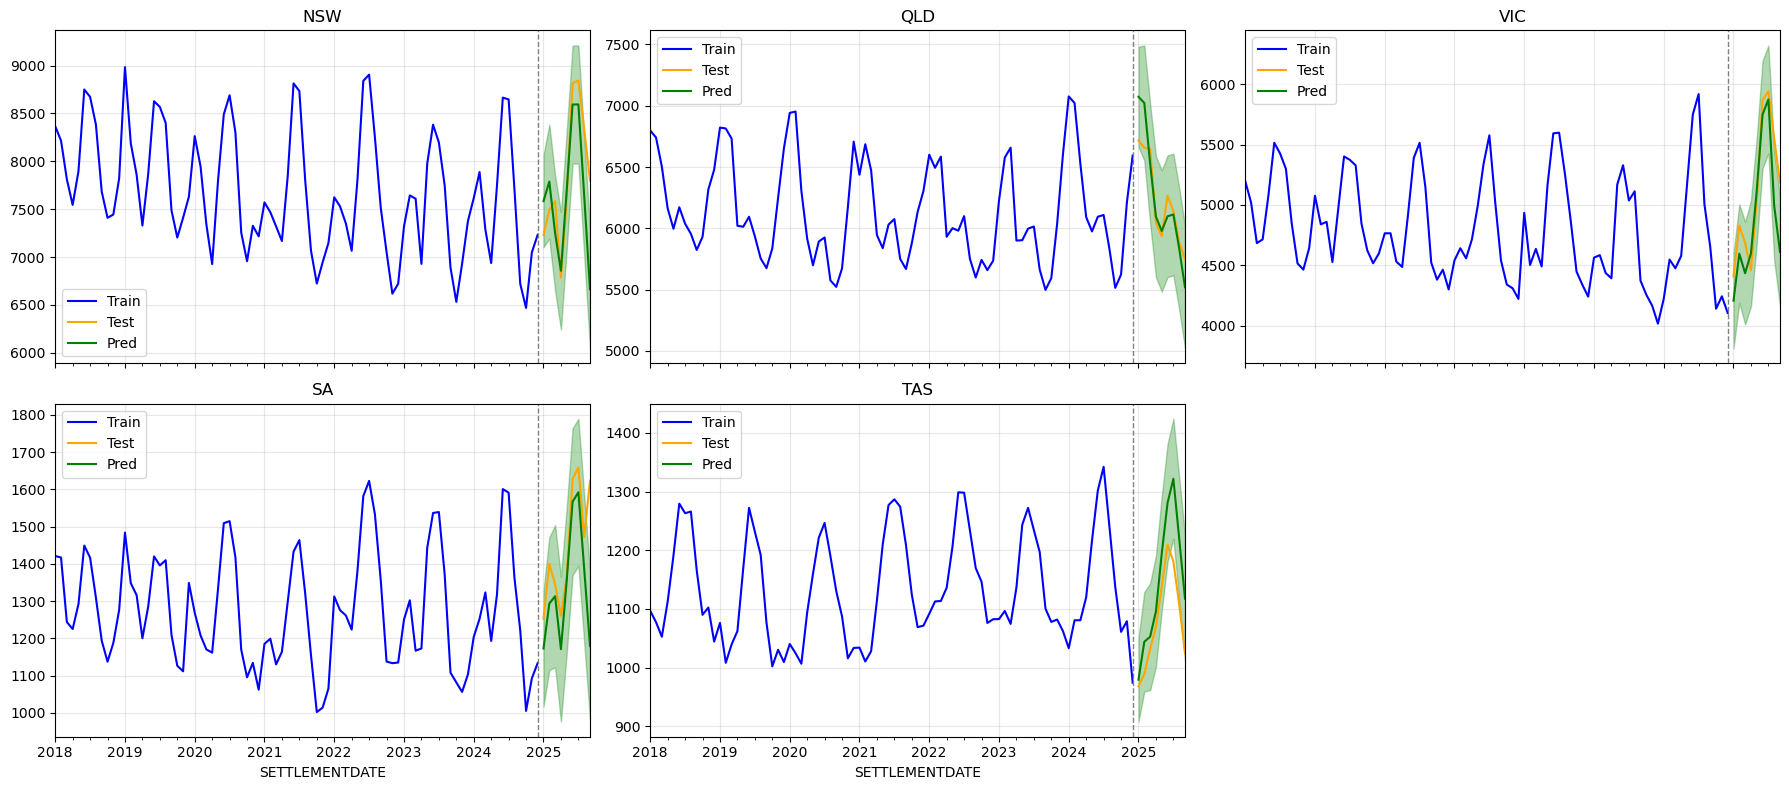

In [508]:
# plot forecasts from SARIMA
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)

axes = axes.flatten()

for i, name in enumerate(["NSW", "QLD", "VIC", "SA", "TAS"]):
    ax = axes[i]
    
    train_list[name].plot(ax=ax, label='Train', color='blue')
    test_list[name].plot(ax=ax, label='Test', color='orange')
    preds[name].plot(ax=ax, label='Pred', color='green')
    
    if name in intervals:
        ax.fill_between(intervals[name].index, 
                       intervals[name]['mean_ci_lower'], 
                       intervals[name]['mean_ci_upper'], 
                       color='green', alpha=0.3)
    
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)
    ax.grid(True, alpha=0.3)
    
    ax.set_title(name)
    ax.legend()

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [509]:
def walk_forward(y_train, y_test, order, seasonal_order):
    history = y_train.copy()
    means, lowers, uppers = [], [], []

    for t in range(len(y_test)):
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=True, enforce_invertibility=True)
        res = model.fit(disp=False)
        fc = res.get_forecast(1)
        sf = fc.summary_frame()

        means.append(sf['mean'].values[0])
        lowers.append(sf['mean_ci_lower'].values[0])
        uppers.append(sf['mean_ci_upper'].values[0])
        
        history = pd.concat([history, y_test.iloc[[t]]])
        
    return pd.DataFrame(
        {"mean": means, "lower": lowers, "upper": uppers},
        index=y_test.index
    )

In [510]:
preds_roll = {}
intervals_roll = {}
rows_roll = []

for name in ["NSW", "QLD", "VIC", "SA", "TAS"]:
    row = opt.loc[opt["variable"].eq(name)].iloc[0]
    order, seasonal_order = tuple(row["order"]), tuple(row["seasonal_order"])

    yhat_df = walk_forward(train_list[name], test_list[name], order, seasonal_order)
    yhat_mean = yhat_df["mean"].astype(float)

    preds_roll[name]     = yhat_mean
    intervals_roll[name] = yhat_df[["lower","upper"]] 

    # Align just in case (and ensure numeric)
    y_true = test_list[name].reindex(yhat_mean.index).astype(float)

    mae  = mean_absolute_error(y_true, yhat_mean)
    rmse = root_mean_squared_error(y_true, yhat_mean)

    rows_roll.append({
        "series": name, "order": order, "seasonal_order": seasonal_order,
        "test_len": len(yhat_mean), "MAE": mae, "RMSE": rmse
    })

metrics_roll = pd.DataFrame(rows_roll).set_index("series").sort_index()
pred_df_roll = pd.concat(preds_roll, axis=1)
print(metrics_roll)

            order seasonal_order  test_len         MAE        RMSE
series                                                            
NSW     (2, 1, 2)  (0, 1, 0, 12)         9  307.986979  370.249585
QLD     (1, 1, 1)  (0, 1, 0, 12)         9  163.585633  200.903561
SA      (3, 1, 3)  (0, 1, 0, 12)         9   92.798166  140.215436
TAS     (1, 1, 1)  (0, 1, 0, 12)         9   27.244308   36.611635
VIC     (3, 1, 3)  (0, 1, 0, 12)         9  220.932193  257.078804


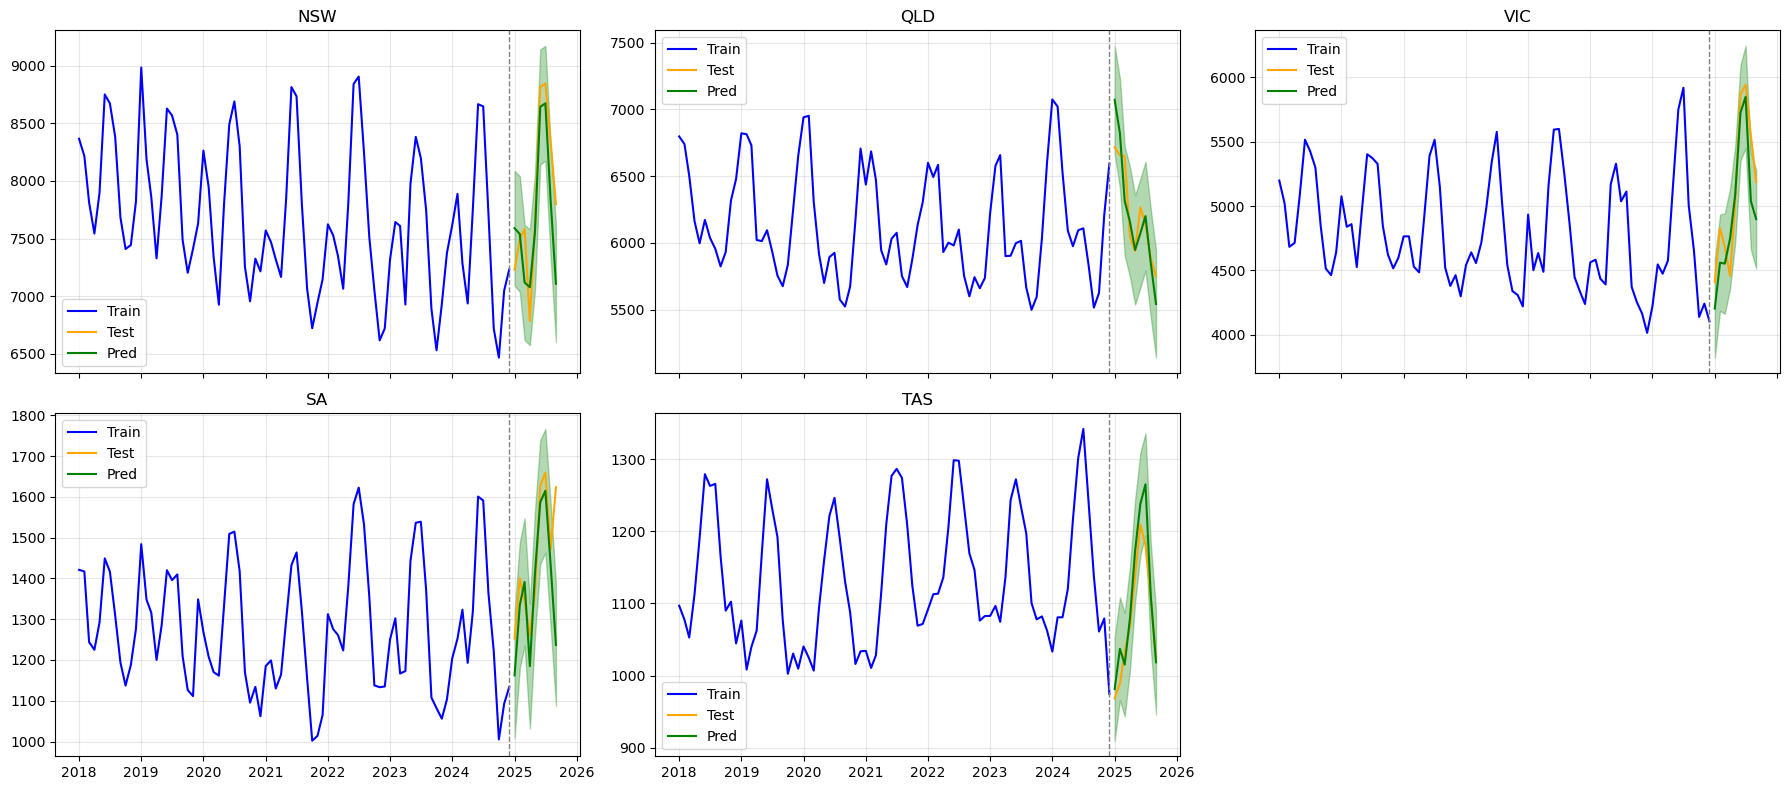

In [511]:
# plot forecasts from SARIMA
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i, name in enumerate(["NSW", "QLD", "VIC", "SA", "TAS"]):
    ax = axes[i]
    ax.plot(train_list[name].index, train_list[name], label='Train', color='blue')
    ax.plot(test_list[name].index, test_list[name], label='Test', color='orange')
    ax.plot(preds_roll[name].index, preds_roll[name], label='Pred', color='green')
    ax.fill_between(intervals_roll[name].index, intervals_roll[name]['lower'], intervals_roll[name]['upper'], color='green', alpha=0.3)
    ax.set_title(name)
    ax.legend()
    # vertical split marker at end of training
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)
    ax.grid(True, alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Multivariate models

In [512]:
weather_data['rh_mean'] = (weather_data['rh_tmax'] + weather_data['rh_tmin']) / 2 #since they are highly correlated -> we make the average the feature
weather_data['mean_temp'] = (weather_data['max_temp'] + weather_data['min_temp']) / 2
weather_data.drop(columns=['max_temp', 'min_temp', 'rh_tmax', 'rh_tmin'], inplace=True)

In [513]:
import holidays
datasets = [("NSW", NSW_data), ("QLD", QLD_data), ("VIC", VIC_data), ("TAS", TAS_data), ("SA", SA_data)]

for state, df in datasets:
    df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
    df.sort_values('SETTLEMENTDATE', inplace=True)
    # df.set_index('SETTLEMENTDATE', inplace=True)

    # Adding time-based features
    d = df['SETTLEMENTDATE']
    df['Year'] = d.dt.year
    df['Month'] = d.dt.month
    df['Quarter'] = d.dt.quarter

    df['DaysInMonth'] = d.dt.days_in_month

    # Adding holiday related features 
    years = range(int(df["Year"].min()), int(df["Year"].max()) + 1)
    hol = holidays.Australia(subdiv=state, years=years)

    hol_month = (
        pd.Series(1, index=pd.to_datetime(list(hol.keys())))
          .to_frame("is_hol")
          .assign(ym=lambda s: s.index.to_period("M"))
          .groupby("ym")["is_hol"].sum())
    
    df["ym"] = d.dt.to_period("M")
    df["HolidayCount"]  = df["ym"].map(hol_month).fillna(0).astype(int)
    df["HolidayShare"]  = df["HolidayCount"] / df["DaysInMonth"]
    # months since start of dataset
    df["t"] = ((df["Year"] - df["Year"].min()) * 12 + (df["Month"] - df["Month"].min()))

    # df['t'] = (df.Hour * 60 + df.Minute) / 60
    df.drop(columns=['ym', 'DaysInMonth', 'REGION', 'PERIODTYPE'], inplace=True)
    df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 476976 entries, 0 to 8927
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SETTLEMENTDATE  476976 non-null  datetime64[ns]
 1   TOTALDEMAND     476976 non-null  float64       
 2   RRP             476976 non-null  float64       
 3   Year            476976 non-null  int32         
 4   Month           476976 non-null  int32         
 5   Quarter         476976 non-null  int32         
 6   HolidayCount    476976 non-null  int32         
 7   HolidayShare    476976 non-null  float64       
 8   t               476976 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(5)
memory usage: 27.3 MB
<class 'pandas.core.frame.DataFrame'>
Index: 477840 entries, 0 to 8927
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SETTLEMENTDATE  477840 non-nul

In [514]:
# Making monthly weather data
wd = weather_data.copy()
wd['date'] = pd.to_datetime(wd['YYYY-MM-DD'])

w_m = (wd.groupby(["state", pd.Grouper(key="date", freq="MS")])
         .agg(rain=("daily_rain","sum"),
              mean_temp=("mean_temp","mean"),
              radiation=("radiation","mean"),
              rh_mean=("rh_mean","mean"))
         .reset_index()
         .rename(columns={"date":"MONTH_START"}))
w_m["ym"] = w_m["MONTH_START"].dt.to_period("M")
w_m = w_m.sort_values(["state","ym"])
w_m.head()

state MONTH_START   rain  mean_temp  radiation    rh_mean       ym
0   NSW  2018-01-01  48.08  24.443548  24.767742  60.374355  2018-01
1   NSW  2018-02-01  67.17  22.859643  21.632500  62.022321  2018-02
2   NSW  2018-03-01  59.05  21.110806  18.177419  65.336290  2018-03
3   NSW  2018-04-01  27.77  18.971833  14.829333  66.325167  2018-04
4   NSW  2018-05-01  23.24  12.716774  11.416129  69.951452  2018-05

In [515]:
# Convert to dict first
datasets = {"NSW": NSW_data, "QLD": QLD_data, "VIC": VIC_data, "TAS": TAS_data, "SA": SA_data}

base_weather = ["rain", "mean_temp", "radiation", "rh_mean"]

for state in datasets.keys():
    df = datasets[state]
    w = w_m[w_m["state"] == state].set_index("ym")[base_weather]

    df["ym"] = df["SETTLEMENTDATE"].dt.to_period("M")
    df = df.merge(w, how="left", left_on="ym", right_index=True)
    df.drop(columns=["ym"], inplace=True)

    # update both dict and variable in global namespace
    datasets[state] = df
    globals()[f"{state}_data"] = df   # <-- this line makes NSW_data, QLD_data, etc. update

    print(f"{state} merged shape:", df.shape)

NSW merged shape: (476976, 13)
QLD merged shape: (477840, 13)
VIC merged shape: (469200, 13)
TAS merged shape: (477840, 13)
SA merged shape: (477840, 13)


In [516]:
for state, df in datasets.items():
    df.info()
    print('***')

<class 'pandas.core.frame.DataFrame'>
Index: 476976 entries, 0 to 8927
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   SETTLEMENTDATE  476976 non-null  datetime64[ns]
 1   TOTALDEMAND     476976 non-null  float64       
 2   RRP             476976 non-null  float64       
 3   Year            476976 non-null  int32         
 4   Month           476976 non-null  int32         
 5   Quarter         476976 non-null  int32         
 6   HolidayCount    476976 non-null  int32         
 7   HolidayShare    476976 non-null  float64       
 8   t               476976 non-null  int32         
 9   rain            476976 non-null  float64       
 10  mean_temp       476976 non-null  float64       
 11  radiation       476976 non-null  float64       
 12  rh_mean         476976 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int32(5)
memory usage: 41.8 MB
***
<class 'pandas.core.frame.D

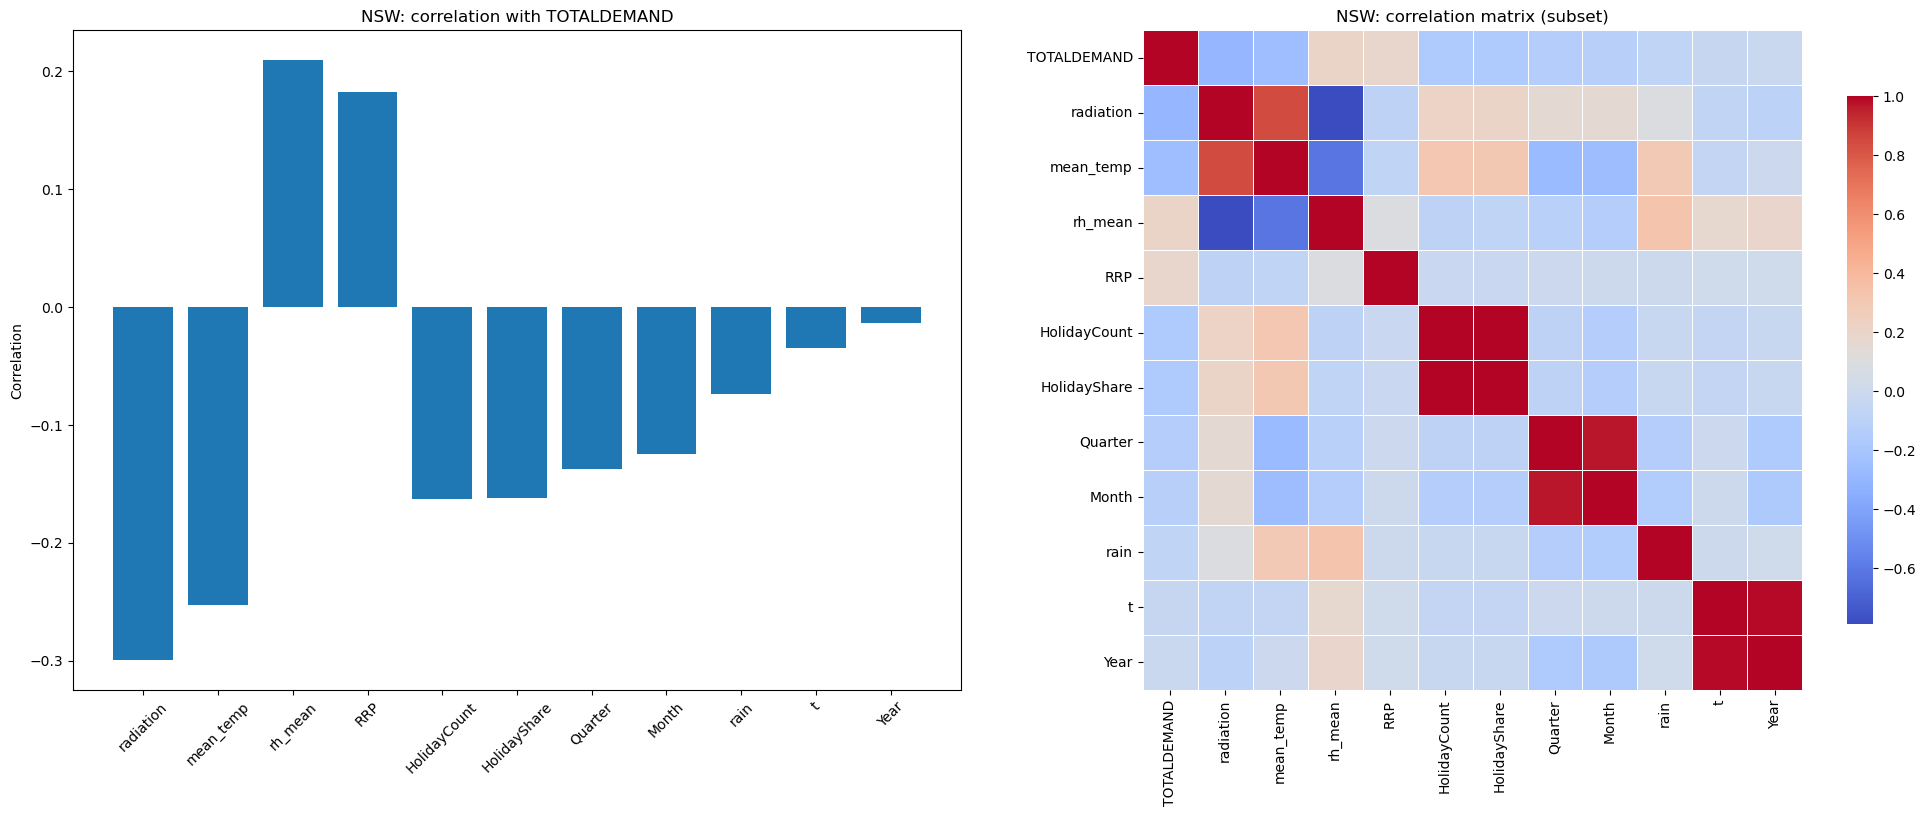

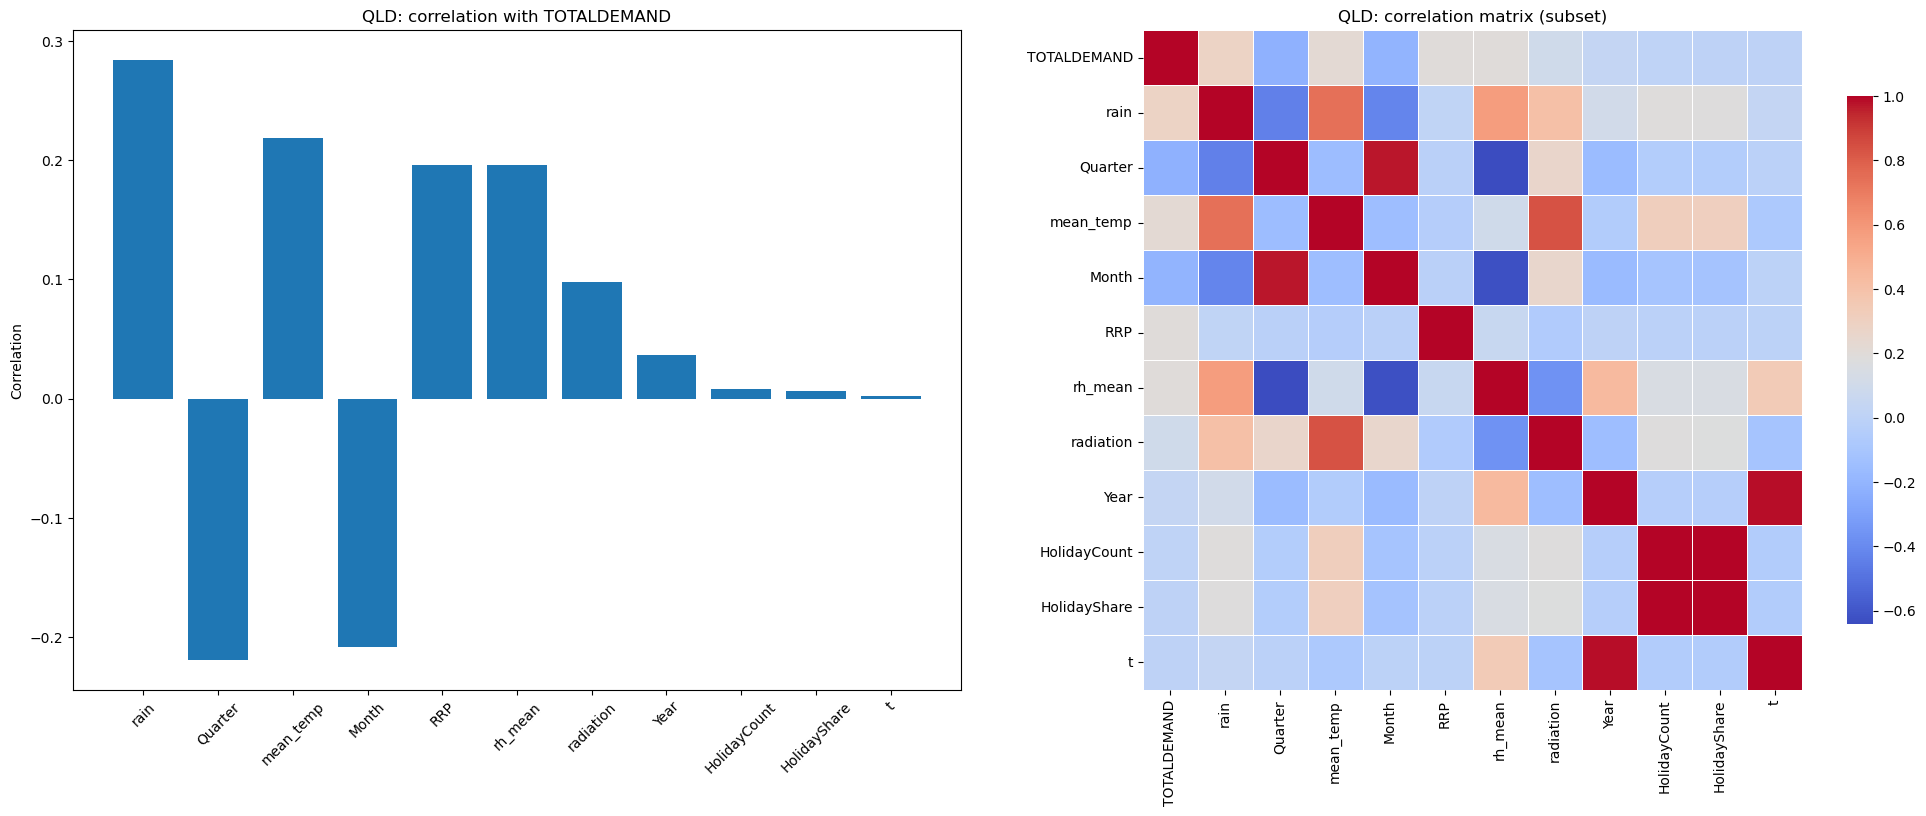

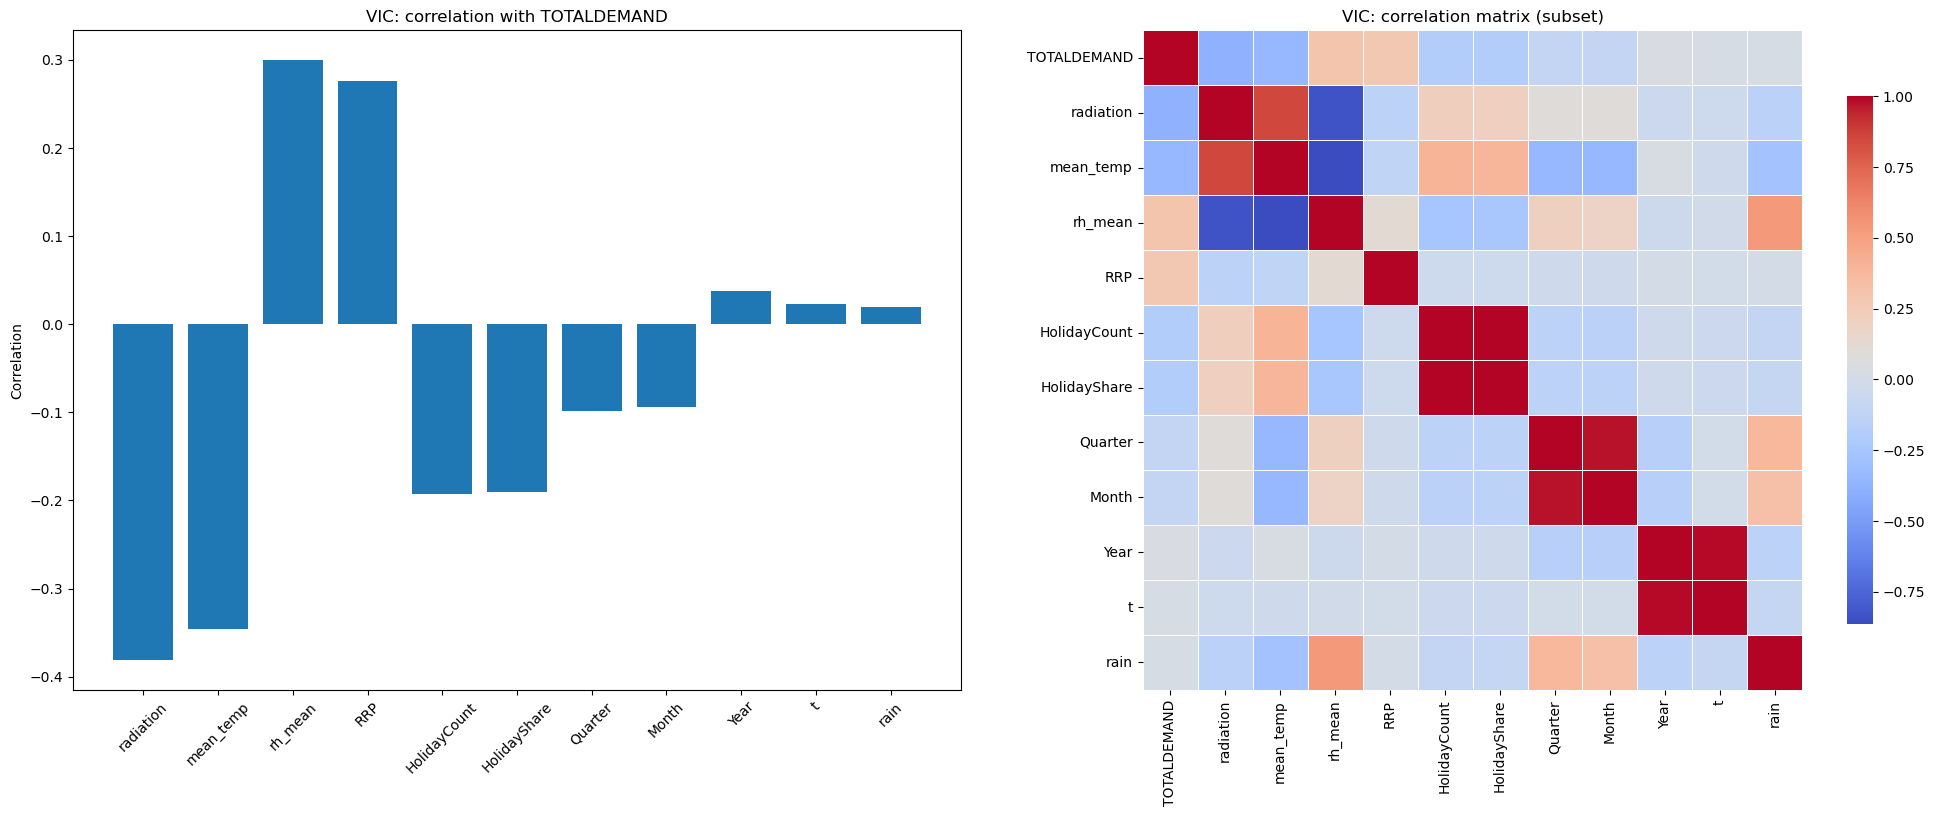

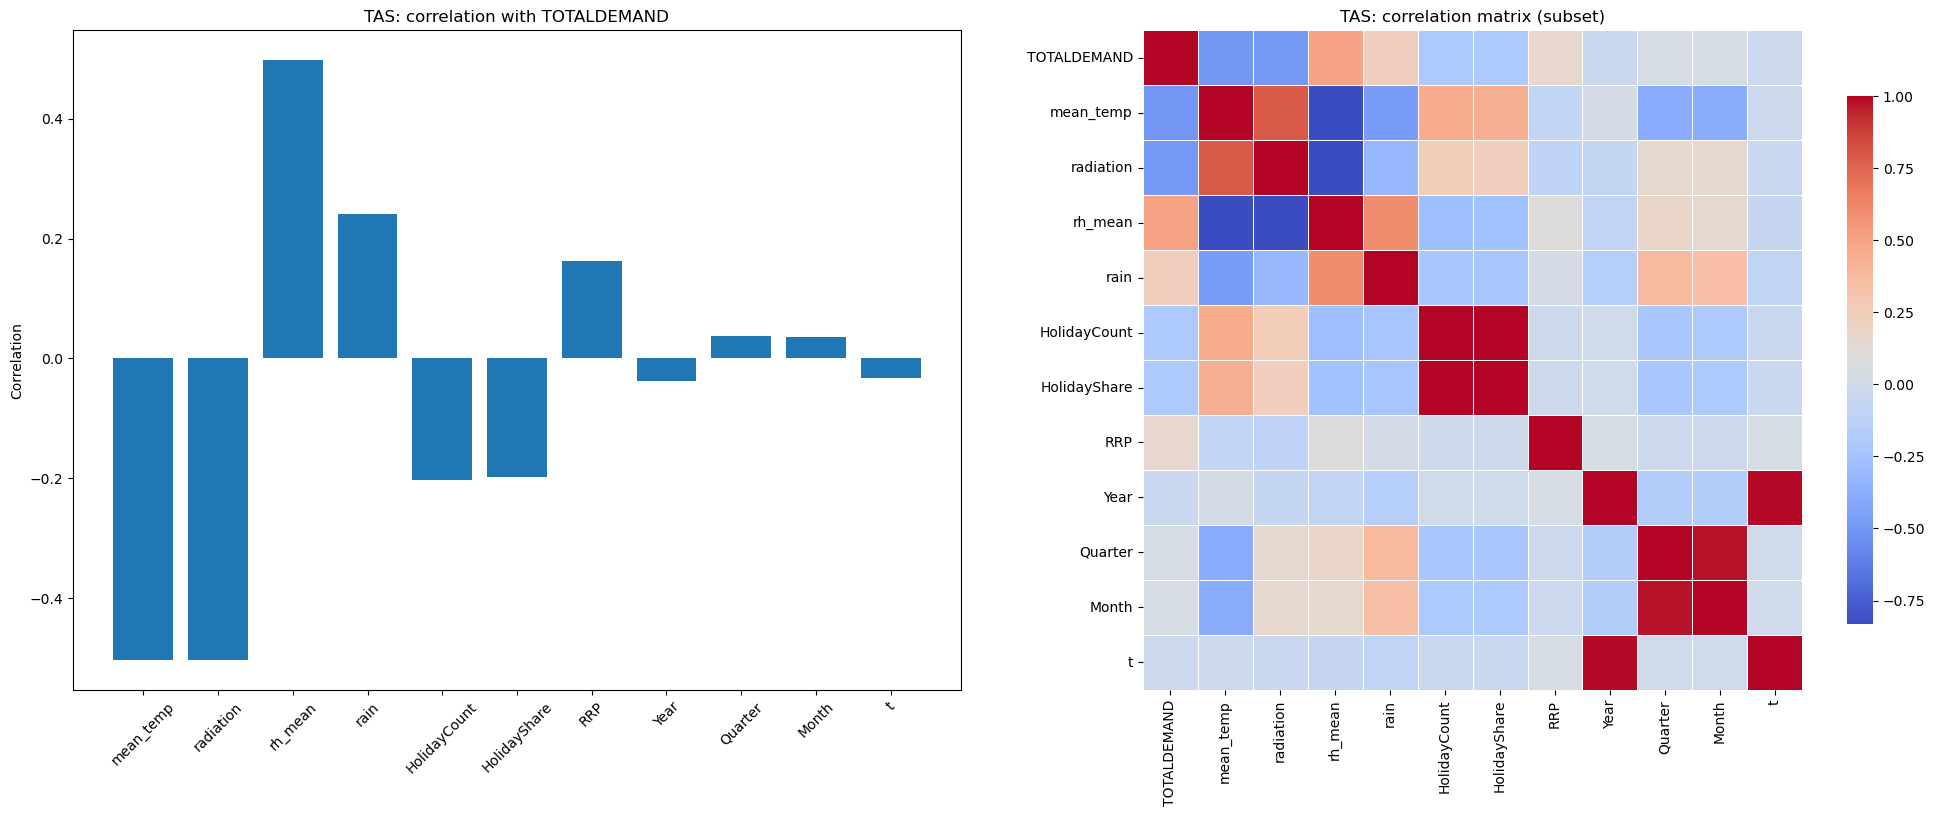

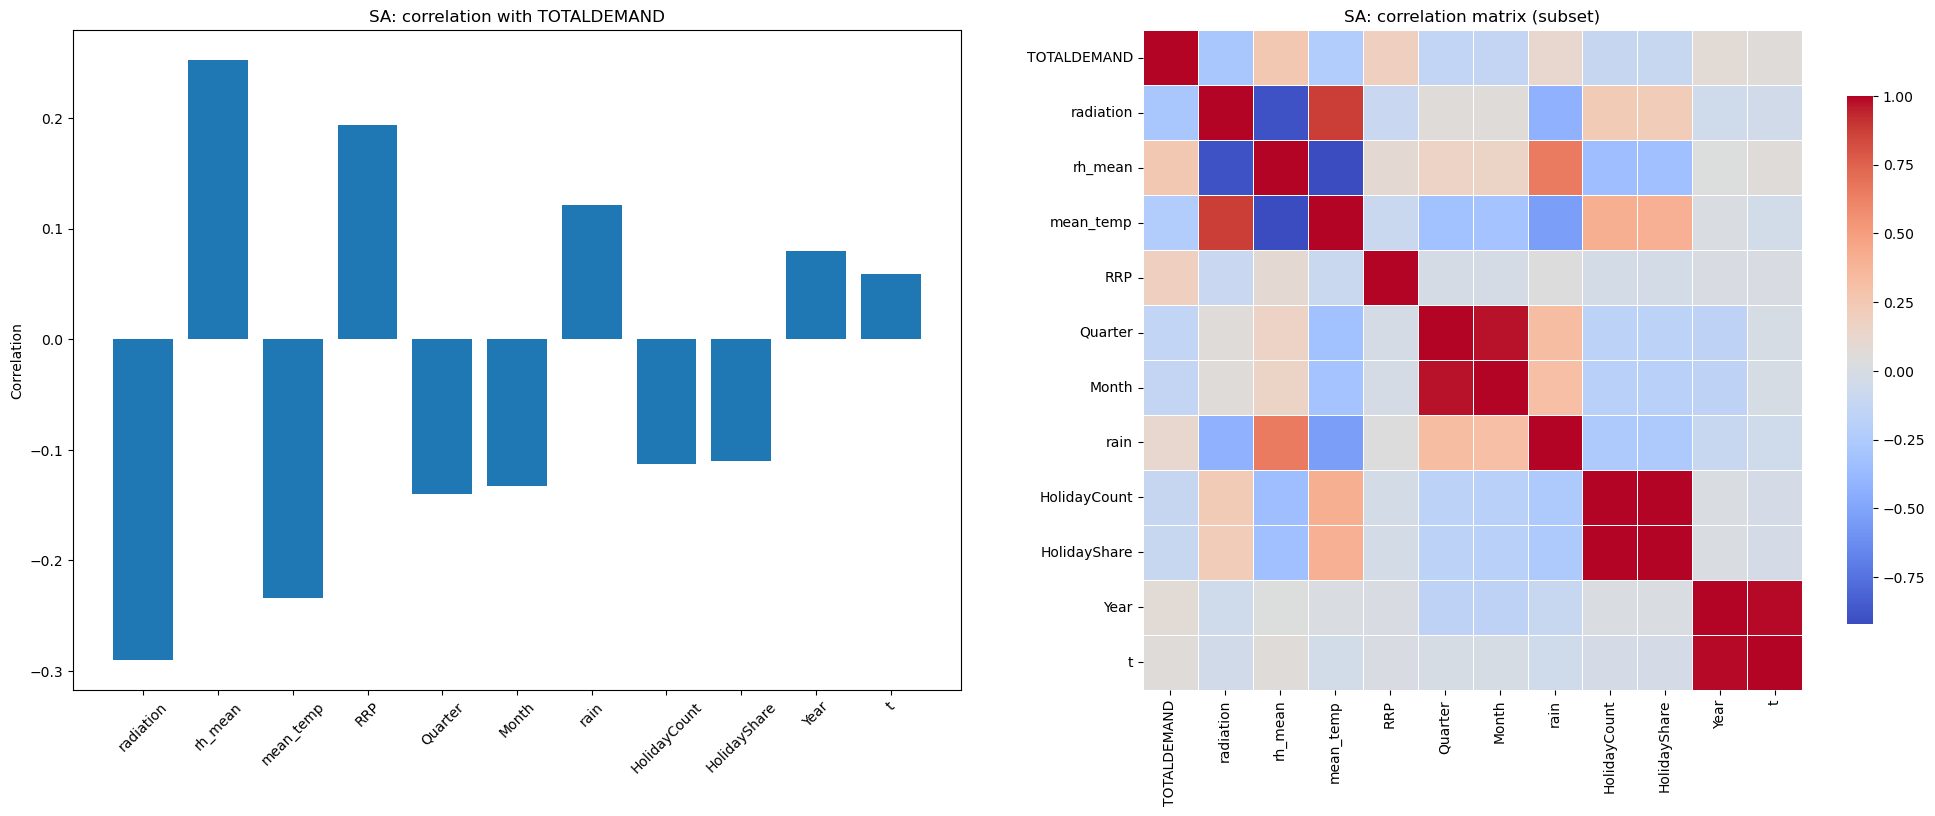

In [517]:
TOP = 15  # how many strongest correlations to show in barplot

for state, df in datasets.items():
    g = df.copy()

    # Choose target name present in this frame
    target = 'TOTALDEMAND' if 'TOTALDEMAND' in g.columns else ('y' if 'y' in g.columns else None)
    if target is None:
        print(f"[{state}] No TOTALDEMAND or y column found. Skipping.")
        continue

    # Coerce target to numeric
    g[target] = pd.to_numeric(g[target], errors='coerce')

    # Try to coerce other columns that might be numeric-like strings
    for c in g.columns:
        if g[c].dtype == 'object':
            # Only attempt if values look numeric; otherwise leave as object
            try:
                g[c] = pd.to_numeric(g[c], errors='ignore')
            except Exception:
                pass

    # Drop Period dtype columns (e.g., 'ym'); they can’t go into corr()
    per_cols = [c for c in g.columns if pd.api.types.is_period_dtype(g[c])]
    if per_cols:
        g = g.drop(columns=per_cols)

    # Keep numeric columns
    num = g.select_dtypes(include=[np.number]).copy()

    if target not in num.columns:
        print(f"[{state}] '{target}' is not numeric after coercion. dtypes={g.dtypes.get(target)}. Skipping.")
        continue

    # Remove all-NaN columns and constant columns (zero variance)
    nunique = num.nunique(dropna=True)
    const_cols = nunique[nunique <= 1].index.tolist()
    if const_cols:
        num = num.drop(columns=const_cols, errors='ignore')

    # If target got dropped by constant filter, skip
    if target not in num.columns:
        print(f"[{state}] '{target}' is constant or NaN-only. Skipping.")
        continue

    corr = num.corr(numeric_only=True)

    # 1) correlations with the target (sorted by absolute value)
    s = corr[target].drop(labels=[target]).dropna()
    s = s.reindex(s.abs().sort_values(ascending=False).index)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Barplot of strongest correlations with target
    top_s = s.head(TOP)
    axes[0].bar(top_s.index, top_s.values)
    axes[0].set_title(f"{state}: correlation with {target}")
    axes[0].set_ylabel("Correlation")
    axes[0].tick_params(axis='x', rotation=45)

    # Heatmap (cap size to keep legible)
    cm = corr.copy()
    # (optional) only show up to, say, 30 columns with strongest |corr| to the target
    keep_cols = [target] + s.head(29).index.tolist()
    cm = cm.loc[keep_cols, keep_cols]

    sns.heatmap(cm, ax=axes[1], annot=False, fmt=".2f", cmap='coolwarm',
                cbar_kws={"shrink": .8}, linewidths=0.5, square=True)
    axes[1].set_title(f"{state}: correlation matrix (subset)")

    plt.tight_layout()
    plt.show()

In [518]:
month_list = [("QLD_m", QLD_m), ("NSW_m", NSW_m), ("VIC_m", VIC_m), ("SA_m", SA_m), ("TAS_m", TAS_m)]

columns_to_drop = ['PERIODTYPE', 'REGION_STD', 'REGION']
NSW_m = NSW_m.drop(columns=columns_to_drop, axis=1)
QLD_m = QLD_m.drop(columns=columns_to_drop, axis=1)
VIC_m = VIC_m.drop(columns=columns_to_drop, axis=1)
SA_m = SA_m.drop(columns=columns_to_drop, axis=1)
TAS_m = TAS_m.drop(columns=columns_to_drop, axis=1)

## Dynamic regression (ARIMA + Linear) + Seasonal encoding: Monthly dummies

In [519]:
def prep_monthly(df, region_name: str):
    import pandas as pd

    # --- make a copy
    if isinstance(df, pd.Series):
        g = df.copy().to_frame()             # column name = series.name (e.g., 'NSW')
        # rename the only data column to 'y'
        valcol = g.columns[0]
        g = g.rename(columns={valcol: 'y'})
        # ensure we have a 'ds' column
        if isinstance(g.index, (pd.DatetimeIndex, pd.PeriodIndex)):
            g = g.rename_axis('ds').reset_index()
        else:
            g = g.reset_index().rename(columns={g.columns[0]: 'ds'})
    else:
        g = df.copy()
        # pick value column
        if 'TOTALDEMAND' in g.columns:
            valcol = 'TOTALDEMAND'
        elif region_name in g.columns:
            valcol = region_name
        else:
            # fallback: the first numeric column
            num_cols = g.select_dtypes(include='number').columns.tolist()
            if not num_cols:
                raise ValueError(f"{region_name}: no numeric column found for y")
            valcol = num_cols[0]
        g = g.rename(columns={valcol: 'y'})

        # ensure 'ds'
        if 'ds' in g.columns:
            pass
        elif 'SETTLEMENTDATE' in g.columns:
            g = g.rename(columns={'SETTLEMENTDATE': 'ds'})
        else:
            g = g.reset_index().rename(columns={g.columns[0]: 'ds'})

    # coerce types & keep only the standard columns
    g['ds'] = pd.to_datetime(g['ds'], errors='coerce')
    g['unique_id'] = region_name
    g = g[['unique_id', 'ds', 'y']].sort_values('ds')
    g['y'] = pd.to_numeric(g['y'], errors='coerce')

    return g

nsw = prep_monthly(NSW_m, 'NSW')
qld = prep_monthly(QLD_m, 'QLD')
vic = prep_monthly(VIC_m, 'VIC')
sa = prep_monthly(SA_m, 'SA')
tas = prep_monthly(TAS_m, 'TAS')

df_all = pd.concat([nsw, qld, vic, sa, tas], ignore_index=True)

In [520]:
# df_all must have columns: unique_id ('NSW','QLD',...), ds (datetime), y
df_all['ds'] = pd.to_datetime(df_all['ds'])
df_all = df_all.sort_values(['unique_id','ds']).copy()

# calendar + trend
df_all['Month']       = df_all['ds'].dt.month
df_all['Quarter']     = df_all['ds'].dt.quarter
df_all['DaysInMonth'] = df_all['ds'].dt.days_in_month
df_all['t']           = df_all.groupby('unique_id').cumcount().astype(float)

# season label
season_map = {12:'summer',1:'summer',2:'summer',
              3:'autumn',4:'autumn',5:'autumn',
              6:'winter',7:'winter',8:'winter',
              9:'spring',10:'spring',11:'spring'}
df_all['Season'] = pd.Categorical(df_all['Month'].map(season_map),
                                  categories=['summer','autumn','winter','spring'],
                                  ordered=True)

# fourier K = 3 for monthly (P=12)
P = 12
for k in (1,2,3):
    df_all[f'sin{k}'] = np.sin(2*np.pi*k*df_all['Month']/P)
    df_all[f'cos{k}'] = np.cos(2*np.pi*k*df_all['Month']/P)

# merge weather monthly table 
wm2 = w_m.copy()
wm2 = wm2.rename(columns={'state':'unique_id'})
wm2['ym'] = pd.to_datetime(wm2['MONTH_START']).dt.to_period('M')

df_all['ds'] = pd.to_datetime(df_all['ds'])
df_all['ym'] = df_all['ds'].dt.to_period('M')

new_weather_cols = ['rain','mean_temp','radiation','rh_mean']

df_all = df_all.merge(wm2[['unique_id','ym'] + new_weather_cols], on=['unique_id','ym'], how='left', validate='m:1')
df_all = df_all.drop(columns='ym')

# sanity check
print('share rows with no weather', df_all[new_weather_cols].isna().all(axis=1).mean())

# one hot numeric exogs (Szn) and rebuild EXOG list
desired_exog = [
    'Month','Quarter','Season','DaysInMonth','HolidayShare','t',
    'sin1','cos1','sin2','cos2','sin3','cos3',
    'rain','mean_temp','radiation','rh_mean'
]

# keep only features that actually exist now
EXOG_VARS = [c for c in desired_exog if c in df_all.columns]

missing = sorted(set(desired_exog) - set(EXOG_VARS))
if missing:
    print("skipping missing exogs:", missing)

H = 9
def add_split(g):
    g = g.sort_values('ds').copy()
    g['is_test'] = False
    g.loc[g.index[-H:], 'is_test'] = True
    return g

df_all = df_all.groupby('unique_id', group_keys=False).apply(add_split)

train_sf = df_all[df_all['is_test']==False][['unique_id','ds','y'] + EXOG_VARS]
test_X   = df_all[df_all['is_test']==True ][['unique_id','ds']      + EXOG_VARS]

share rows with no weather 0.0
skipping missing exogs: ['HolidayShare']


In [521]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

sf = StatsForecast(models=[AutoARIMA(seasonal=False, max_p=3, max_q=3)], freq='MS', n_jobs=1)
sf = sf.fit(df=train_sf, target_col='y')
fc = sf.predict(h=H, X_df=test_X, level=[80,95])

In [522]:
eval_df = df_all[df_all['is_test']][['unique_id','ds','y']].merge(
    fc[['unique_id','ds','AutoARIMA']], on=['unique_id','ds'], how='left'
).rename(columns={'AutoARIMA':'yhat'})

def mae(a,f): return np.mean(np.abs(a-f))
def rmse(a,f): return np.sqrt(np.mean((a-f)**2))

metrics = []
for k,g in eval_df.groupby('unique_id'):
    metrics.append({
        'region':k,
        'MAE':mae(g['y'],g['yhat']),
        'RMSE':rmse(g['y'],g['yhat'])
    })
print(pd.DataFrame(metrics))

  region         MAE        RMSE
0    NSW  389.873244  470.548373
1    QLD  147.603907  198.561284
2     SA  126.448773  167.235448
3    TAS   63.113114   74.100790
4    VIC  331.765921  386.036807


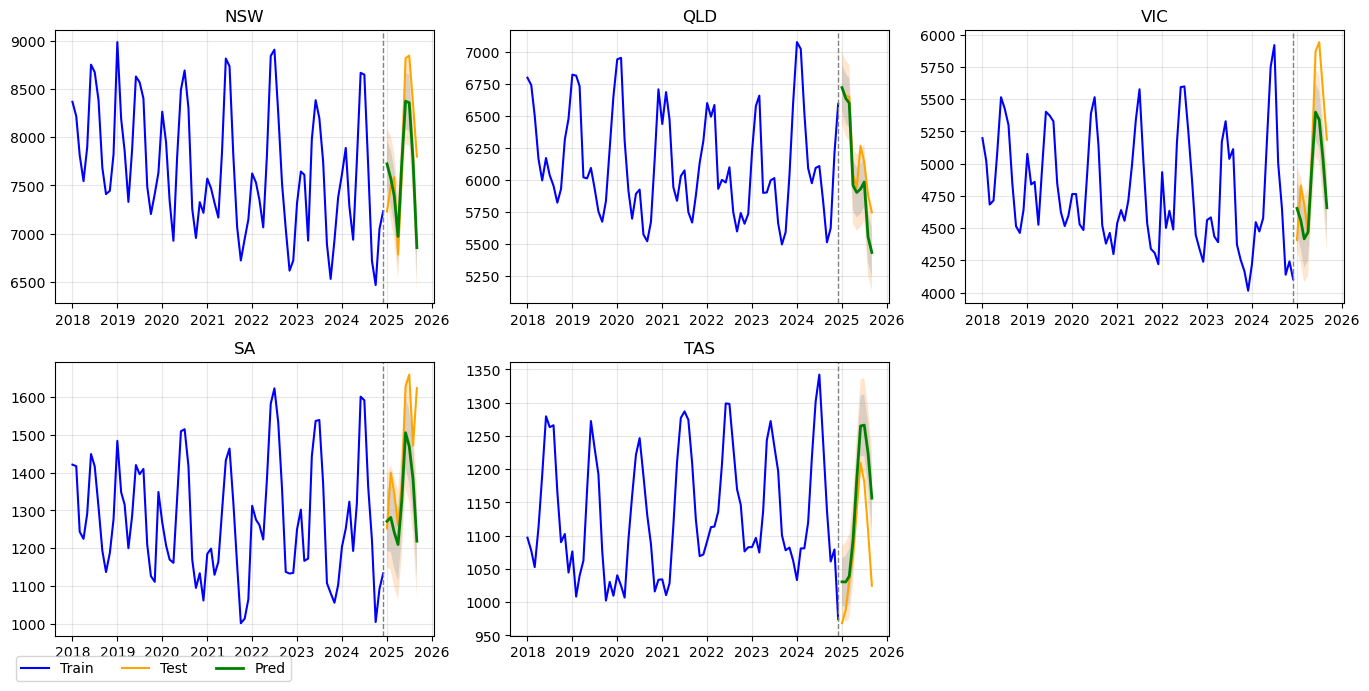

In [523]:
from matplotlib.dates import DateFormatter

def plot_dynamic_regression_panels(df_all, fc, regions=('NSW','QLD','VIC','SA','TAS'),
                                   model_col='AutoARIMA', levels=(80,95), ncols=3):
    df_all = df_all.copy(); df_all['ds'] = pd.to_datetime(df_all['ds'])
    fc = fc.copy();         fc['ds']     = pd.to_datetime(fc['ds'])

    n = len(regions)
    ncols = max(1, ncols)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.6*ncols, 3.4*nrows),
                             sharex=False, squeeze=False)
    axes_flat = axes.ravel()

    for i, region in enumerate(regions):
        ax = axes_flat[i]
        g  = df_all[df_all['unique_id'] == region].sort_values('ds')
        tr = g[g['is_test'] == False]
        te = g[g['is_test'] == True]
        gf = fc[fc['unique_id'] == region].sort_values('ds')

        if not tr.empty: ax.plot(tr['ds'], tr['y'], color='blue', label='Train')
        if not te.empty: ax.plot(te['ds'], te['y'], color='orange', label='Test')
        if (model_col in gf.columns) and not gf.empty:
            ax.plot(gf['ds'], gf[model_col], color='green', lw=2, label='Pred')

        for L in sorted(levels):
            lo, hi = f'{model_col}-lo-{L}', f'{model_col}-hi-{L}'
            if lo in gf.columns and hi in gf.columns:
                ax.fill_between(gf['ds'].values, gf[lo].values, gf[hi].values, alpha=0.20, edgecolor='none')

        ax.set_title(region); ax.grid(alpha=0.25)
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))
        ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)
        ax.grid(True, alpha=0.3)

    # turn off any unused cells
    for j in range(n, nrows*ncols):
        axes_flat[j].set_visible(False)

    # single legend (from first axis with handles)
    for ax in axes_flat:
        h, lab = ax.get_legend_handles_labels()
        if h:
            fig.legend(h, lab, loc='lower left', bbox_to_anchor=(0.01, -0.02), ncol=3)
            break

    fig.tight_layout()
    plt.show()

plot_dynamic_regression_panels(df_all, fc, regions=('NSW','QLD','VIC', 'SA', 'TAS'),
                               model_col='AutoARIMA', levels=(80,95), ncols=3)

### Feature importance

In [524]:
def _rmse(a, f):
    a = np.asarray(a); f = np.asarray(f)
    return float(np.sqrt(np.mean((a - f)**2)))

def permutation_importance_arimax(sf, df_all, test_X, baseline_fc,
                                  repeats=20, random_state=0, agg='mean'):
    rng = np.random.default_rng(random_state)
    # exact exog names and order used by the fitted model
    exog_cols = list(sf._exog)
    # model column name in fc (e.g. 'AutoARIMA')
    model_col = [c for c in baseline_fc.columns if c not in ('unique_id','ds')][0]
    # forecast horizon per series
    H = test_X.groupby('unique_id').size().iloc[0]

    # --- baseline RMSE per region ---
    base_eval = (df_all[df_all['is_test']][['unique_id','ds','y']]
                 .merge(baseline_fc[['unique_id','ds',model_col]], on=['unique_id','ds'])
                 .rename(columns={model_col:'yhat'}))
    base_scores = base_eval.groupby('unique_id').apply(lambda g: _rmse(g['y'], g['yhat'])).rename('RMSE_base')

    rows = []
    for feat in exog_cols:
        per_uid = {uid: [] for uid in test_X['unique_id'].unique()}
        for _ in range(repeats):
            Xp = test_X.copy()
            # permute within each region
            for uid, g in Xp.groupby('unique_id'):
                vals = g[feat].to_numpy().copy()
                rng.shuffle(vals)
                Xp.loc[g.index, feat] = vals
            # ensure column order exactly matches what sf expects
            Xp = Xp[['unique_id','ds'] + exog_cols]
            fcp = sf.predict(h=H, X_df=Xp)

            eval_p = (df_all[df_all['is_test']][['unique_id','ds','y']]
                      .merge(fcp[['unique_id','ds',model_col]], on=['unique_id','ds'])
                      .rename(columns={model_col:'yhatp'}))
            for uid, g in eval_p.groupby('unique_id'):
                per_uid[uid].append(_rmse(g['y'], g['yhatp']) - base_scores.loc[uid])

        # aggregate deltas
        for uid, ls in per_uid.items():
            rows.append({
                'feature': feat,
                'unique_id': uid,
                'delta_RMSE': float(np.mean(ls) if agg=='mean' else np.median(ls))
            })

    imp = pd.DataFrame(rows)
    imp_overall = (imp.groupby('feature')['delta_RMSE']
                     .mean()
                     .sort_values(ascending=False)
                     .rename('importance')
                     .reset_index())
    return imp, imp_overall

def plot_feature_importance(imp_overall, top=15, title='Permutation importance (ΔRMSE)'):
    topdf = imp_overall.head(top).iloc[::-1]
    plt.figure(figsize=(7,5))
    plt.barh(topdf['feature'], topdf['importance'])
    plt.xlabel('Increase in RMSE when permuted (higher = more important)')
    plt.title(title); plt.tight_layout(); plt.show()

        feature  importance
0          sin1  599.145361
1          cos1  206.041579
2     mean_temp  121.003486
3     radiation   88.166003
4       Quarter   80.839480
5          sin2   79.547049
6        Season   74.224367
7          sin3   64.981080
8          cos2   56.595393
9         Month   11.952945
10         cos3    4.231250
11  DaysInMonth    4.195050
12            t   -3.395831
13         rain   -5.090221
14      rh_mean  -10.630063


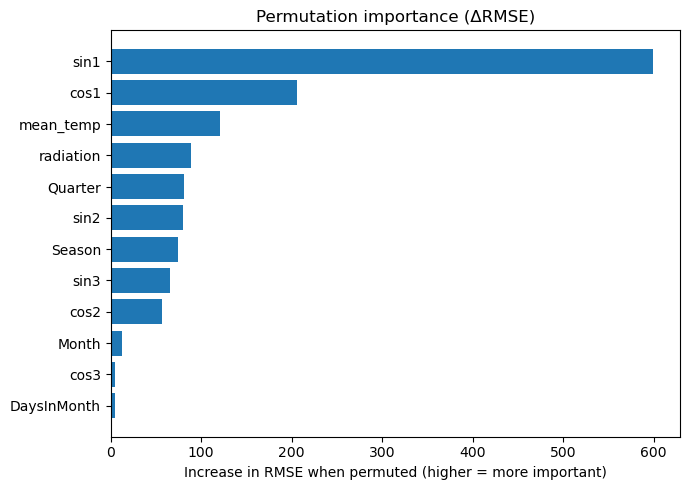

In [525]:
# 0) exact exogenous set (and order) used at fit time
required_exog = list(sf._exog)

# 1) rebuild test_X to match the model’s exog exactly
#    (create month dummies first if your model used them)
if any(c.startswith('m_') for c in required_exog) and 'm_2' not in df_all.columns:
    m = df_all['ds'].dt.month.astype(int)
    dums = pd.get_dummies(m, prefix='m', drop_first=True, dtype=float)
    df_all = pd.concat([df_all, dums], axis=1)

test_X = df_all[df_all['is_test']][['unique_id','ds'] + required_exog].copy()
# enforce column order just to be safe
test_X = test_X[['unique_id','ds'] + required_exog]

# 2) horizon per region (use your forecast as source of truth)
H = fc.groupby('unique_id').size().iloc[0]   # should be 12

# 3) run permutation importance (the helper I gave earlier)
imp_by_region, imp_overall = permutation_importance_arimax(
    sf=sf, df_all=df_all, test_X=test_X, baseline_fc=fc,
    repeats=50, random_state=42
)

print(imp_overall.head(15))      # ranked features (ΔRMSE)
plot_feature_importance(imp_overall, top=12)

## Seasonal encoding: *Fourier* + *Monthly dummies*


In [526]:
def mae(a,f):  return np.mean(np.abs(a-f))
def rmse(a,f): return np.sqrt(np.mean((a-f)**2))
def smape(a,f): return 100*np.mean(2*np.abs(f-a)/(np.abs(a)+np.abs(f)+1e-9))

# seasonal naive vs current forecast df `fc`
base_rows = []
for region, g in df_all.groupby('unique_id'):
    g = g.sort_values('ds')
    tr = g[g['is_test']==False]['y'].to_numpy()
    te = g[g['is_test']==True].copy()
    yhat = tr[-9:]  # last 9 months as forecast
    te['yhat_snaive'] = yhat
    base_rows.append({
        "region": region,
        "MAE_snaive": mae(te['y'], te['yhat_snaive']),
        "RMSE_snaive": rmse(te['y'], te['yhat_snaive']),
        "sMAPE_snaive": smape(te['y'], te['yhat_snaive'])
    })
print(pd.DataFrame(base_rows))

  region   MAE_snaive  RMSE_snaive  sMAPE_snaive
0    NSW  1101.457987  1367.800892     14.273571
1    QLD   496.819062   560.870902      8.083535
2     SA   295.611678   359.272152     21.602418
3    TAS   143.808500   168.397157     12.658997
4    VIC   941.329397  1107.047434     18.732488


In [527]:
def add_fourier_monthly(g, K=3):
    m = g['ds'].dt.month.values
    for k in range(1, K+1):
        g[f'sin{k}m'] = np.sin(2*np.pi*k*m/12)
        g[f'cos{k}m'] = np.cos(2*np.pi*k*m/12)
    return g

def prune_qr(X, tol=1e-10):
    A = X.values.astype(float)
    Q, R = np.linalg.qr(A)
    keep = np.where(np.abs(np.diag(R)) > tol)[0]
    return X.iloc[:, keep]

In [528]:
def build_adv(df, region, use_log=False, base_temp=18.0):
    # --- 0) Normalize input to a DataFrame with ['ds','y'] ---
    if isinstance(df, pd.Series):
        idx = df.index
        if isinstance(idx, pd.PeriodIndex):
            ds = idx.to_timestamp(how='S')
        else:
            ds = pd.to_datetime(idx)
        g = pd.DataFrame({'ds': ds, 'y': pd.to_numeric(df.values, errors='coerce')})
    else:
        g = df.copy()

        # Make/choose 'ds'
        if isinstance(g.index, pd.PeriodIndex):
            ds = g.index.to_timestamp(how='S')
            g = g.reset_index(drop=False).rename(columns={'index': 'ds'})
            g['ds'] = pd.to_datetime(ds)
        elif isinstance(g.index, pd.DatetimeIndex):
            g = g.reset_index(drop=False).rename(columns={'index': 'ds'})
        else:
            if 'ds' in g.columns:
                pass
            elif 'SETTLEMENTDATE' in g.columns:
                g = g.rename(columns={'SETTLEMENTDATE': 'ds'})
            elif 'ym' in g.columns:
                g['ds'] = pd.PeriodIndex(g['ym']).to_timestamp(how='S')
            elif {'Year','Month'}.issubset(g.columns):
                g['ds'] = pd.to_datetime(dict(
                    year=g['Year'].astype(int),
                    month=g['Month'].astype(int),
                    day=1
                ))
            else:
                # try a few common names
                for c in ['date','Date','timestamp','INDEX','index']:
                    if c in g.columns:
                        g['ds'] = pd.to_datetime(g[c], errors='coerce')
                        if g['ds'].notna().any():
                            break
                if 'ds' not in g.columns:
                    raise KeyError("Could not create 'ds'. Provide a datetime column or an index of periods/datetimes.")

        # Choose y
        if 'y' not in g.columns:
            if 'TOTALDEMAND' in g.columns:
                g = g.rename(columns={'TOTALDEMAND': 'y'})
            elif region in g.columns:
                g = g.rename(columns={region: 'y'})
            else:
                # pick first numeric column as fallback
                cand = [c for c in g.select_dtypes(include=[np.number]).columns if c != 'ds']
                if not cand:
                    raise KeyError(f"{region}: no numeric column to use as target 'y'.")
                g = g.rename(columns={cand[0]: 'y'})

    # Ensure types
    g['ds'] = pd.to_datetime(g['ds'])
    g['y']  = pd.to_numeric(g['y'], errors='coerce')
    g['unique_id'] = region

    # --- 1) Calendar and trend ---
    g['DaysInMonth'] = g['ds'].dt.days_in_month
    g['t'] = g.groupby('unique_id').cumcount().astype(float)

    # --- 2) CDD/HDD from mean temperature (or max/min fallback) ---
    if 'mean_temp' in g.columns:
        tmean = g['mean_temp'].astype(float)
    elif {'max_temp','min_temp'}.issubset(g.columns):
        tmean = (g['max_temp'].astype(float) + g['min_temp'].astype(float)) / 2.0
    else:
        tmean = None

    if tmean is not None:
        g['CDD'] = np.clip(tmean - base_temp, 0, None)
        g['HDD'] = np.clip(base_temp - tmean, 0, None)
    else:
        g['CDD'] = 0.0
        g['HDD'] = 0.0

    # --- 3) Fourier (K=3) for monthly seasonality (P=12) ---
    m = g['ds'].dt.month.values
    for k in (1, 2, 3):
        g[f'sin{k}'] = np.sin(2*np.pi*k*m/12)
        g[f'cos{k}'] = np.cos(2*np.pi*k*m/12)

    # optional log transform of y
    if use_log:
        g['y'] = np.log(g['y'])

    # --- 4) Select exogs that actually exist (numeric) ---
    # NOTE: weather names match your w_m table
    Xcols = [
    't','DaysInMonth','HolidayShare','CDD','HDD',
    'sin1','cos1','sin2','cos2','sin3','cos3',
    'rain','mean_temp','radiation','rh_mean'
    ]
    Xcols = [c for c in Xcols if c in g.columns]
    X = g[Xcols].select_dtypes(include=[np.number]).copy()
    X = X.loc[:, X.nunique(dropna=True) > 1]  # drop constants

    out = pd.concat([g[['unique_id','ds','y']].reset_index(drop=True),
                     X.reset_index(drop=True)], axis=1)
    return out

In [529]:
nsw = build_adv(NSW_m, 'NSW', use_log=False)
qld = build_adv(QLD_m, 'QLD', use_log=False)
vic = build_adv(VIC_m, 'VIC', use_log=False)
sa  = build_adv(SA_m,  'SA',  use_log=False)
tas = build_adv(TAS_m, 'TAS', use_log=False)

df2 = pd.concat([nsw, qld, vic, sa, tas], ignore_index=True)
wm2 = wm2.rename(columns={'MONTH_START':'ds', 'state':'unique_id'})
df2 = pd.merge(
    df2, 
    wm2[['unique_id','ds','rain','mean_temp','radiation','rh_mean']], 
    on=['unique_id','ds'], 
    how='left'
)
print(df2[['unique_id','ds','y']].head())

  unique_id         ds            y
0       NSW 2018-01-01  8365.807357
1       NSW 2018-02-01  8216.016957
2       NSW 2018-03-01  7813.076559
3       NSW 2018-04-01  7544.269535
4       NSW 2018-05-01  7896.182534


In [530]:
H = 9
def add_split(g):
    g = g.sort_values('ds').copy()
    g['is_test'] = False
    g.loc[g.index[-H:], 'is_test'] = True
    return g

df2 = df2.groupby('unique_id', group_keys=False).apply(add_split)
EXOG = [c for c in df2.columns if c not in ('unique_id','ds','y','is_test')]

train_sf = df2[df2['is_test']==False][['unique_id','ds','y']+EXOG]
test_X   = df2[df2['is_test']==True ][['unique_id','ds']+EXOG]

sf2 = StatsForecast(
    models=[AutoARIMA(season_length=12, max_p=3, max_q=3, max_P=1, max_Q=1)],
    freq='MS',
    n_jobs=1
)
sf2 = sf2.fit(df=train_sf, target_col='y')
fc2  = sf2.predict(h=H, X_df=test_X, level=[80,95])

# metrics
eval2 = df2[df2['is_test']][['unique_id','ds','y']].merge(
    fc2[['unique_id','ds','AutoARIMA']], on=['unique_id','ds'], how='left'
).rename(columns={'AutoARIMA':'yhat'})

rows=[]
for r,g in eval2.groupby('unique_id'):
    rows.append({
        "region": r,
        "MAE":  mae(g['y'], g['yhat']),
        "RMSE": rmse(g['y'], g['yhat']),
        "sMAPE": smape(g['y'], g['yhat'])
    })
print(pd.DataFrame(rows))

  region         MAE        RMSE     sMAPE
0    NSW  390.450591  467.489854  5.018557
1    QLD  148.148635  196.906739  2.505222
2     SA  123.038685  181.790956  8.718192
3    TAS   61.654999   72.361958  5.495265
4    VIC  324.004337  381.498180  6.300781


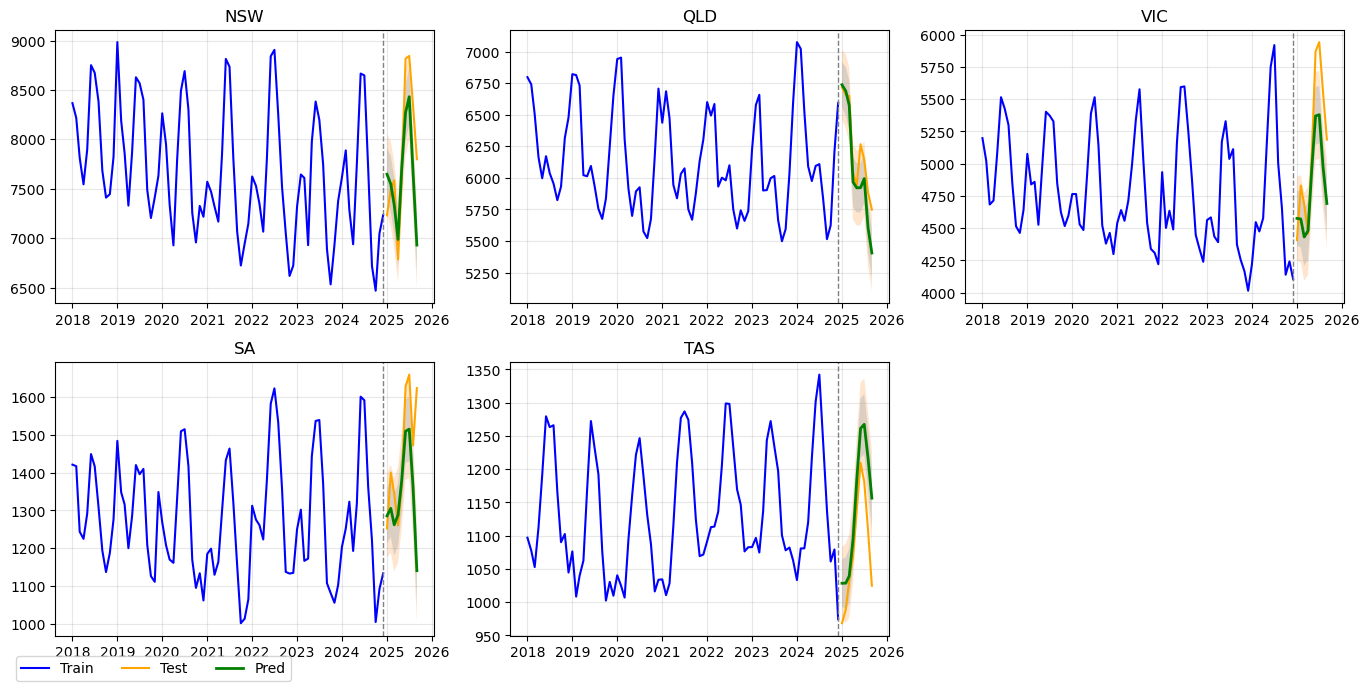

In [531]:
df2 = df2.sort_values(['unique_id','ds']).copy()
df2['is_test'] = False
for uid, g in fc2.groupby('unique_id'):
    ds_fore = set(pd.to_datetime(g['ds']))
    mask = (df2['unique_id'].eq(uid) & df2['ds'].isin(ds_fore))
    df2.loc[mask, 'is_test'] = True

plot_dynamic_regression_panels(
    df2, fc2,
    regions=('NSW','QLD','VIC', 'SA', 'TAS'),
    model_col='AutoARIMA',
    levels=(80,95)
)

### Feature Importance

In [532]:
def _rmse(a, f): 
    a = np.asarray(a); f = np.asarray(f)
    return float(np.sqrt(np.mean((a - f)**2)))

def perm_importance_groups(sf, df_all, test_X, baseline_fc, groups,
                           repeats=50, random_state=42, agg='mean'):
    rng = np.random.default_rng(random_state)
    exog_cols = list(sf._exog)
    model_col = [c for c in baseline_fc.columns if c not in ('unique_id','ds')][0]
    H = test_X.groupby('unique_id').size().iloc[0]

    base_eval = (df_all[df_all['is_test']][['unique_id','ds','y']]
        .merge(baseline_fc[['unique_id','ds',model_col]], on=['unique_id','ds'])
        .rename(columns={model_col:'yhat'}))
    base_rmse = base_eval.groupby('unique_id').apply(lambda g: _rmse(g['y'], g['yhat'])).rename('RMSE_base')

    rows=[]
    for gname, cols in groups.items():
        per_uid = {uid: [] for uid in test_X['unique_id'].unique()}
        for _ in range(repeats):
            Xp = test_X.copy()
            # permute ALL columns in the group within each region
            for uid, g in Xp.groupby('unique_id'):
                idx = g.index
                for c in cols:
                    vals = g[c].to_numpy().copy()
                    rng.shuffle(vals)
                    Xp.loc[idx, c] = vals
            Xp = Xp[['unique_id','ds'] + exog_cols]  # enforce order
            fcp = sf.predict(h=H, X_df=Xp)

            eval_p = (df_all[df_all['is_test']][['unique_id','ds','y']]
                .merge(fcp[['unique_id','ds',model_col]], on=['unique_id','ds'])
                .rename(columns={model_col:'yhatp'}))

            for uid, g in eval_p.groupby('unique_id'):
                per_uid[uid].append(_rmse(g['y'], g['yhatp']) - base_rmse.loc[uid])

        for uid, deltas in per_uid.items():
            rows.append({'group': gname,
                         'unique_id': uid,
                         'delta_RMSE': float(np.mean(deltas) if agg=='mean' else np.median(deltas))})

    imp = pd.DataFrame(rows)
    overall = (imp.groupby('group')['delta_RMSE']
                 .mean().sort_values(ascending=False)
                 .rename('importance').reset_index())
    return imp, overall

def plot_group_importance(overall, top=10, title='Permutation importance (groups, ΔRMSE)'):
    df = overall.head(top).iloc[::-1]
    plt.figure(figsize=(7,5))
    plt.barh(df['group'], df['importance'])
    plt.xlabel('Increase in RMSE when permuted (higher = more important)')
    plt.title(title); plt.tight_layout(); plt.show()

In [533]:
exog_cols = list(sf2._exog)           # what the fitted models expect

GROUPS = {
    'Trend/Calendar': [c for c in exog_cols if c in ['t','DaysInMonth','HolidayShare']],
    'CDD/HDD'       : [c for c in exog_cols if c in ['CDD','HDD']],
    'Weather'       : [c for c in exog_cols if c in ['rain','mean_temp','radiation','rh_mean']],  # <- updated
    'Fourier (K=3)' : [c for c in exog_cols if c in ['sin1','cos1','sin2','cos2','sin3','cos3']],  # <- updated
    'Month dummies' : [c for c in exog_cols if c.startswith('m_')],
}
GROUPS = {k:v for k,v in GROUPS.items() if len(v)>0}  # drop empties
print("Exog used by model:", exog_cols)
for k,v in GROUPS.items():
    print(f"{k}: {len(v)} -> {v[:6]}{'...' if len(v)>6 else ''}")

Exog used by model: ['t', 'DaysInMonth', 'sin1', 'cos1', 'sin2', 'cos2', 'sin3', 'cos3', 'rain', 'mean_temp', 'radiation', 'rh_mean']
Trend/Calendar: 2 -> ['t', 'DaysInMonth']
Weather: 4 -> ['rain', 'mean_temp', 'radiation', 'rh_mean']
Fourier (K=3): 6 -> ['sin1', 'cos1', 'sin2', 'cos2', 'sin3', 'cos3']


            group  importance
0   Fourier (K=3)  295.911592
1         Weather  207.106386
2  Trend/Calendar   -2.572644


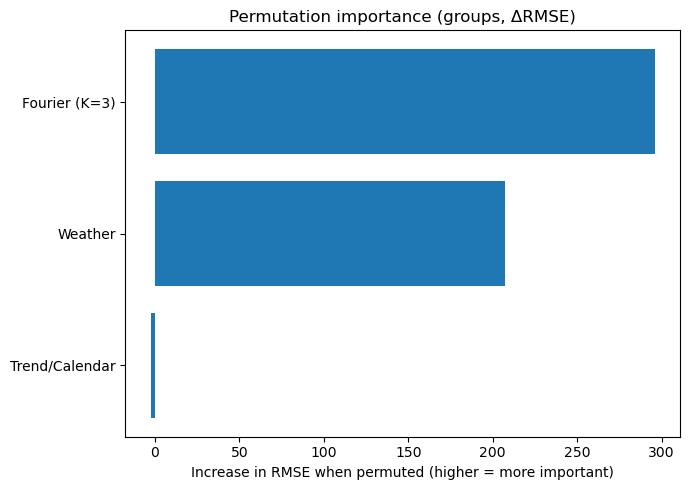

In [534]:
imp_by_region, imp_overall = perm_importance_groups(
    sf2, df2, test_X, fc2, GROUPS, repeats=50, random_state=42
)
print(imp_overall)      # ranked groups by ΔRMSE
plot_group_importance(imp_overall)

## DHR

In [535]:
def make_full_rank_exog(train_df: pd.DataFrame, exog_cols, tol=1e-10, verbose=True):
    """
    Ensure the exogenous set is full rank for *every* unique_id in train_df.
    Iteratively drops the lowest-variance column that causes deficiency.
    Returns a cleaned, common exog list to use for all regions.
    """
    cols = list(exog_cols)

    # 0) drop global constants/NaN-only cols first
    cols = [c for c in cols if train_df[c].nunique(dropna=True) > 1]

    changed = True
    while changed:
        changed = False
        for uid, g in train_df.groupby('unique_id'):
            X = g[cols].to_numpy()
            if X.size == 0:
                continue
            # add constant because AutoARIMA adds one during the OLS pre-step
            Xc = np.column_stack([np.ones(len(X)), X])
            rank = np.linalg.matrix_rank(Xc, tol=tol)
            if rank < Xc.shape[1]:
                # not full rank for this uid -> drop the smallest-variance column
                variances = g[cols].var(ddof=0).fillna(0.0)
                drop_col = variances.idxmin()
                if verbose:
                    print(f"[{uid}] dropping '{drop_col}' to restore full rank "
                          f"(rank={rank}/{Xc.shape[1]}, var={variances[drop_col]:.3g})")
                cols.remove(drop_col)
                changed = True
                break  # restart the loop and check all uids again
    if verbose:
        print("Final EXOG:", cols)
    return cols

def add_fourier_monthly(df, K, prefix="F"):
    g = df.copy()
    m = g['ds'].dt.month.values
    for k in range(1, K+1):
        g[f'{prefix}_sin{k}'] = np.sin(2*np.pi*k*m/12)
        g[f'{prefix}_cos{k}'] = np.cos(2*np.pi*k*m/12)
    return g

def run_dhr_fixed(df_all, K_list=(1,2,3,4,5,6), H=12):
    # start from base features only (remove any old sin/cos and month dummies)
    drop_cols = [c for c in df_all.columns if c.startswith(('sin','cos','m_'))]
    base_df = df_all.drop(columns=drop_cols, errors='ignore').copy()

    base = ['t','DaysInMonth','HolidayShare','CDD','HDD',
            'rain','radiation','rh_tmax','rh_tmin']
    base = [c for c in base if c in base_df.columns]

    results, forecasts = [], {}

    for K in K_list:
        g = base_df[['unique_id','ds','y'] + base].copy()
        g = add_fourier_monthly(g, K, prefix="F")
        four = sum(([f'F_sin{k}', f'F_cos{k}'] for k in range(1, K+1)), [])
        EXOG = base + four

        # split: last H per region = test
        g = g.sort_values(['unique_id','ds']).copy()
        g['is_test'] = g.groupby('unique_id')['ds'].transform(
            lambda s: s.rank(method='first') > (s.size - H)
        )

        train = g[g['is_test']==False][['unique_id','ds','y'] + EXOG]
        testX = g[g['is_test']==True ][['unique_id','ds']      + EXOG]

        # ---- NEW: ensure full rank for every region
        EXOG_clean = make_full_rank_exog(train, EXOG, tol=1e-10, verbose=True)
        train = train[['unique_id','ds','y'] + EXOG_clean]
        testX = testX[['unique_id','ds'] + EXOG_clean]

        # Fit ARIMA errors; seasonality handled by Fourier (seasonal=False)
        sf = StatsForecast(
            models=[AutoARIMA(seasonal=False, max_p=3, max_q=3, max_P=0, max_Q=0)],
            freq='MS', n_jobs=1
        )
        sf = sf.fit(df=train, target_col='y')
        fc = sf.predict(h=H, X_df=testX, level=[80,95])

        # metrics
        eval_df = (g[g['is_test']][['unique_id','ds','y']]
                   .merge(fc[['unique_id','ds','AutoARIMA']], on=['unique_id','ds'], how='left')
                   .rename(columns={'AutoARIMA':'yhat'}))
        rows=[]
        for r, gr in eval_df.groupby('unique_id'):
            rows.append({'K':K, 'region':r,
                         'MAE': np.mean(np.abs(gr['y']-gr['yhat'])),
                         'RMSE': float(np.sqrt(np.mean((gr['y']-gr['yhat'])**2)))})
        results.append(pd.DataFrame(rows))
        forecasts[K] = fc

        print(f"K={K} exog used:", list(sf._exog))  # sanity

    return pd.concat(results, ignore_index=True), forecasts

### Feature Importance

Final EXOG: ['t', 'DaysInMonth', 'rain', 'radiation', 'F_sin1', 'F_cos1']
K=1 exog used: ['t', 'DaysInMonth', 'rain', 'radiation', 'F_sin1', 'F_cos1']
Final EXOG: ['t', 'DaysInMonth', 'rain', 'radiation', 'F_sin1', 'F_cos1', 'F_sin2', 'F_cos2']
K=2 exog used: ['t', 'DaysInMonth', 'rain', 'radiation', 'F_sin1', 'F_cos1', 'F_sin2', 'F_cos2']
Final EXOG: ['t', 'DaysInMonth', 'rain', 'radiation', 'F_sin1', 'F_cos1', 'F_sin2', 'F_cos2', 'F_sin3', 'F_cos3']
K=3 exog used: ['t', 'DaysInMonth', 'rain', 'radiation', 'F_sin1', 'F_cos1', 'F_sin2', 'F_cos2', 'F_sin3', 'F_cos3']
Final EXOG: ['t', 'DaysInMonth', 'rain', 'radiation', 'F_sin1', 'F_cos1', 'F_sin2', 'F_cos2', 'F_sin3', 'F_cos3', 'F_sin4', 'F_cos4']
K=4 exog used: ['t', 'DaysInMonth', 'rain', 'radiation', 'F_sin1', 'F_cos1', 'F_sin2', 'F_cos2', 'F_sin3', 'F_cos3', 'F_sin4', 'F_cos4']
Final EXOG: ['t', 'DaysInMonth', 'rain', 'radiation', 'F_sin1', 'F_cos1', 'F_sin2', 'F_cos2', 'F_sin3', 'F_cos3', 'F_sin4', 'F_cos4', 'F_sin5', 'F_cos5']
K=

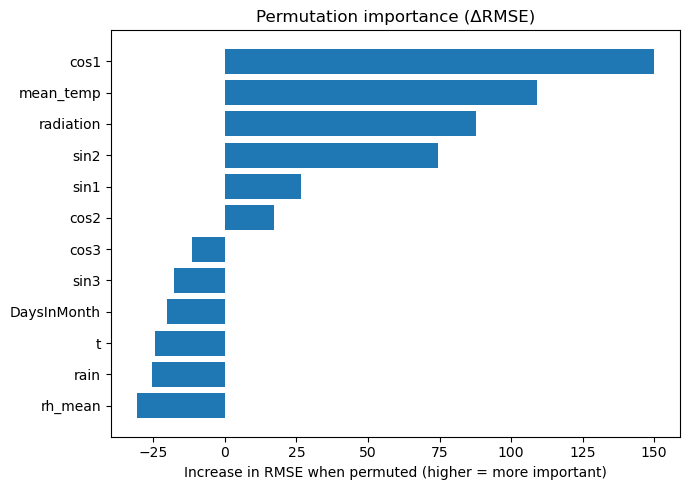

In [536]:
# Ensure df2 has ['unique_id','ds','y'] + base + (it may have old sin/cos/m_*, we drop those inside)
df2 = df2.sort_values(['unique_id','ds']).copy()

scores, fc_by_K = run_dhr_fixed(df2, K_list=(1,2,3,4,5,6), H=12)
print(scores.pivot(index='region', columns='K', values='RMSE'))

K_best = int(scores.groupby('K')['RMSE'].mean().idxmin())
fc_best = fc_by_K[K_best]
print(f"Chosen K={K_best}")

df_plot = df2.copy()
df_plot['is_test'] = False
for uid, gfc in fc_best.groupby('unique_id'):
    mask = (df_plot['unique_id'].eq(uid) & df_plot['ds'].isin(pd.to_datetime(gfc['ds'])))
    df_plot.loc[mask, 'is_test'] = True

imp_by_region, imp_overall = permutation_importance_arimax(
    sf=sf2, df_all=df2, test_X=test_X, baseline_fc=fc_best,
    repeats=50, random_state=42
)

print(imp_overall.head(15))

plot_feature_importance(imp_overall)

# Overall performance

In [537]:
def r_2(y_true, y_pred): 
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    
    return 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

def evaluate_model(name, test_list, preds_dict):
    """
    test_list: dict {region: Series of y_test aligned on ds}
    preds_dict: dict {region: Series of yhat aligned on ds}
    """
    per_reg, macro, micro = eval_overall(test_list, preds_dict)

    # Flatten across all regions for global R²
    y_true = pd.concat(test_list.values())
    y_pred = pd.concat([preds_dict[r] for r in test_list.keys()])

    r2_global = r_2(y_true, y_pred)

    print(f"\n{name} results:")
    print("Overall RMSE (micro):", round(micro["RMSE"], 3))
    print("Overall MAE (micro):", round(micro["MAE"], 3))
    print("Global R²:", round(r2_global, 3))

    return {
        "Model": name,
        "RMSE_micro": micro["RMSE"],
        "MAE_micro": micro["MAE"],
        "R2_global": r2_global
    }

In [538]:
def build_eval_df(df_all, fc, model_name="model"):
    eval_df = (
        df_all[df_all['is_test']][['unique_id','ds','y']]
        .merge(fc[['unique_id','ds', model_name]],
               on=['unique_id','ds'], how='left')
        .rename(columns={model_name: 'yhat'})
    )
    return eval_df

def evaluate_model(name, df_all, fc, test_list, preds_dict, model_name="model"):
    print(f"\n{name} performance:")
    
    # Build evaluation dataframe
    eval_df = build_eval_df(df_all, fc, model_name=model_name)
    
    # Standard per-region, macro, micro eval
    per_region, macro, micro = eval_overall(test_list, preds_dict)
    
    print("Per-region metrics:\n", per_region)
    print("\nOverall (macro avg) RMSE:", round(macro["RMSE"], 2))
    print("Overall (micro/pooled) RMSE:", round(micro["RMSE"], 2))
    print(f"{name} MAE (micro):", round(micro["MAE"], 3))
    
    # Global R²
    r2_global = r_2(eval_df['y'], eval_df['yhat'])
    print(f"Global R² ({name}):", round(r2_global, 2))

In [539]:
test_list = {
    r: g.set_index('ds')['y']
    for r, g in df_all[df_all['is_test']].groupby('unique_id')
    }

preds_dict = {
    r: g.set_index('ds')['AutoARIMA']
    for r, g in fc.groupby('unique_id')
}

eval_df = df_all[df_all['is_test']][['unique_id','ds','y']].merge(
    fc[['unique_id','ds','AutoARIMA']],
    on=['unique_id','ds'], how='left'
).rename(columns={'AutoARIMA': 'yhat'})

# 2) Evaluate
per_region, macro, micro = eval_overall(test_list, preds_dict)

print('Dynamic regression output performance:')
print("Per-region metrics:\n", per_region)
print("\nOverall (macro avg)  RMSE:", round(micro["RMSE"], 2))
print("Overall (micro/pooled) RMSE:", round(micro["RMSE"], 2))
print("Overall MAE:", round(micro["MAE"], 3))
r2_global = r_2(eval_df['y'], eval_df['yhat'])
print("Global R²:", round(r2_global, 2))

Dynamic regression output performance:
Per-region metrics:
   Region  N         MAE        RMSE      MAPE
3    TAS  9   63.113114   74.100790  5.845614
2     SA  9  126.448773  167.235448  8.289033
1    QLD  9  147.603907  198.561284  2.450449
4    VIC  9  331.765921  386.036807  6.248594
0    NSW  9  389.873244  470.548373  4.901175

Overall (macro avg)  RMSE: 297.77
Overall (micro/pooled) RMSE: 297.77
Overall MAE: 211.761
Global R²: 0.99


In [540]:
test_list = {
    r: g.set_index('ds')['y']
    for r, g in df_all[df_all['is_test']].groupby('unique_id')
}

preds_dict_1 = {r: g.set_index('ds')['AutoARIMA'] for r, g in fc.groupby('unique_id')}
preds_dict_2 = {r: g.set_index('ds')['AutoARIMA'] for r, g in fc2.groupby('unique_id')}
preds_dict_3 = {r: g.set_index('ds')['AutoARIMA'] for r, g in fc_best.groupby('unique_id')}

evaluate_model("Dynamic 1", df_all, fc,      test_list, preds_dict_1, model_name="AutoARIMA")
evaluate_model("Dynamic 2", df2,    fc2,     test_list, preds_dict_2, model_name="AutoARIMA")
evaluate_model("Dynamic 3", df2,    fc_best, test_list, preds_dict_3, model_name="AutoARIMA")


Dynamic 1 performance:
Per-region metrics:
   Region  N         MAE        RMSE      MAPE
3    TAS  9   63.113114   74.100790  5.845614
2     SA  9  126.448773  167.235448  8.289033
1    QLD  9  147.603907  198.561284  2.450449
4    VIC  9  331.765921  386.036807  6.248594
0    NSW  9  389.873244  470.548373  4.901175

Overall (macro avg) RMSE: 259.3
Overall (micro/pooled) RMSE: 297.77
Dynamic 1 MAE (micro): 211.761
Global R² (Dynamic 1): 0.99

Dynamic 2 performance:
Per-region metrics:
   Region  N         MAE        RMSE      MAPE
3    TAS  9   61.654999   72.361958  5.712161
2     SA  9  123.038685  181.790956  7.994730
1    QLD  9  148.148635  196.906739  2.450049
4    VIC  9  324.004337  381.498180  6.063589
0    NSW  9  390.450591  467.489854  4.890848

Overall (macro avg) RMSE: 260.01
Overall (micro/pooled) RMSE: 297.03
Dynamic 2 MAE (micro): 209.459
Global R² (Dynamic 2): 0.99

Dynamic 3 performance:
Per-region metrics:
   Region  N         MAE        RMSE      MAPE
3    TAS  